#### ***Imports and Defs***

In [16]:
#import openai
import pandas as pd
from transformers import DistilBertTokenizerFast, DistilBertForTokenClassification, Trainer, TrainingArguments
import torch
import json
import ast
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import TrainerCallback
from copy import deepcopy

import matplotlib.pyplot as plt

from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### ***Data Load***

In [18]:
def extract_values(output_str):
    output_dict = ast.literal_eval(output_str)
    seed_type = output_dict.get('seed_type', None)
    crop_name = output_dict.get('crop_name', None)
    pest_name = output_dict.get('pest_name',  None)
    return seed_type, crop_name, pest_name

In [19]:
data_files = {"train": "train.csv"}
df = load_dataset("ksgr5566/ner", revision="main", data_files = data_files)
df = pd.DataFrame(df['train']).drop(columns = ['Unnamed: 0'], axis = 0 )
df[['seed_type', 'crop_name', 'pest_name']] = df['Output'].apply(lambda x: pd.Series(extract_values(x)))
df =  df.rename(columns =  {'Input':'sentences'})
df.drop(columns=['Output'], inplace=True)
df

,sentences,seed_type,crop_name,pest_name
0,I need seeds for my maize crop.,None,maize,None
1,How can I protect my wheat from pests?,None,wheat,None
2,My rice plants are being attacked by rodents.,None,rice,rodents
3,Which type of seeds are best for draught resis...,draught resistant,None,None
4,My corn crops are infected with caterpillars.,None,corn,caterpillars
...,...,...,...,...
2015,Are there any insect resistant seeds available...,insect resistant,soybeans,None
2016,My orange trees are infested with fruit flies.,None,orange,fruit flies
2017,Which pesticide should I use for my strawberry...,None,strawberry,None
2018,I want to buy pests for my rice field.,None,rice,None


#### ***Encoding Generation***

In [20]:
def create_tags(word_token_mapping, phrase, type_agri_term ='PEST', tags = None):

    if pd.isnull(phrase):
        return(tags)
    elif phrase == '':
        return(tags)
    else :
        phrase_words = phrase.split()

        # Iterate over the word_token_mapping to find the phrase
        for i in range(len(word_token_mapping) - len(phrase_words) + 1):
            # Check if current word matches the first word of the phrase
            if word_token_mapping[i][0] == phrase_words[0]:
                match = True
                for j in range(1, len(phrase_words)):
                    if i+j >= len(word_token_mapping) or word_token_mapping[i+j][0] != phrase_words[j]:
                        match = False
                        break
                # If we found a match, tag the tokens accordingly
                if match:
                    for j, word in enumerate(phrase_words):
                        is_first_token = (j == 0)
                        for _, index in word_token_mapping[i+j][1]:
                            if is_first_token:
                                tags[index] = "B-" + type_agri_term
                                is_first_token = False
                            else:
                                tags[index] = "I-" + type_agri_term

    return (tags)

In [21]:
def create_word_token_mapping(sentence, tokenized_list):
    # Create a copy of the tokenized_list removing [CLS], [SEP], and [PAD], but remember their original indices
    filtered_tokens_with_indices = [(token, idx) for idx, token in enumerate(tokenized_list) if token not in ['[CLS]', '[SEP]', '[PAD]']]

    word_token_mapping = []

    for word in sentence.replace('.',' .').replace('?',' ?').split():
        current_word_tokens = []
        reconstructed_word = ''

        while filtered_tokens_with_indices and reconstructed_word != word:
            token, original_idx = filtered_tokens_with_indices.pop(0)  # Take the first token from the list
            current_word_tokens.append((token, original_idx))
            reconstructed_word += token.replace('#', '')

        if reconstructed_word != word:
            raise ValueError(f"Token mismatch for word '{word}'! Failed to reconstruct from tokens.")

        word_token_mapping.append((word, current_word_tokens))

    return word_token_mapping


In [22]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/home/raid/miniconda3/envs/sam/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [23]:
labels = ["O", "B-CROP", "I-CROP", "B-PEST", "I-PEST", "B-SEED", "I-SEED"]
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}
default_label_id = label2id['O']

In [24]:
sentences = df['sentences'].apply(lambda x: [x.lower()]).to_list()
encodings = tokenizer(sentences, is_split_into_words=True, padding=True, truncation=True, return_tensors="pt")
# encodings['input_ids'] = encodings['input_ids'].to(device)
# encodings['attention_mask'] = encodings['attention_mask'].to(device)
encodings['labels'] = torch.full_like(encodings['input_ids'], default_label_id).to(device)  # Ensure labels are also moved

In [25]:
for i in range(0,df.shape[0]):
    row =  df.iloc[i]
    sentence = row['sentences'].lower()
    crop_name = row['crop_name']
    pest_name =  row['pest_name']
    seed_type =  row['seed_type']

    input_id = encodings['input_ids'][i]
    tokens = tokenizer.convert_ids_to_tokens(input_id)
    word_token_mapping = create_word_token_mapping(sentence, tokens)

    tags =   ['O'] * len(tokens)
    tags = create_tags(word_token_mapping,crop_name, type_agri_term = 'CROP', tags = tags)
    tags = create_tags(word_token_mapping,pest_name, type_agri_term = 'PEST', tags = tags)
    tags = create_tags(word_token_mapping,seed_type, type_agri_term = 'SEED', tags = tags)

    attention_masks = encodings['attention_mask'][i]
    current_labels = [label2id[tag] for tag in tags] + [label2id["O"]] * (len(input_id) - len(tags))
    encodings['labels'][i] = torch.tensor(current_labels)

In [26]:
for i, input_id in enumerate(encodings['input_ids'][0:8]):
    tokens = tokenizer.convert_ids_to_tokens(input_id)
    labels_for_input = [id2label[label_id.item()] for label_id in encodings['labels'][i]]

    print('Original Sentence: ', ' '.join(sentences[i]))
    for token, label in zip(tokens, labels_for_input):
        if token not in ['[CLS]', '[SEP]', '[PAD]']:
            print(f"{token} - {label}")
    print("----" * 10)

Original Sentence:  i need seeds for my maize crop.
i - O
need - O
seeds - O
for - O
my - O
maize - B-CROP
crop - O
. - O
----------------------------------------
Original Sentence:  how can i protect my wheat from pests?
how - O
can - O
i - O
protect - O
my - O
wheat - B-CROP
from - O
pest - O
##s - O
? - O
----------------------------------------
Original Sentence:  my rice plants are being attacked by rodents.
my - O
rice - B-CROP
plants - O
are - O
being - O
attacked - O
by - O
rodents - B-PEST
. - O
----------------------------------------
Original Sentence:  which type of seeds are best for draught resistant crops?
which - O
type - O
of - O
seeds - O
are - O
best - O
for - O
draught - B-SEED
resistant - I-SEED
crops - O
? - O
----------------------------------------
Original Sentence:  my corn crops are infected with caterpillars.
my - O
corn - B-CROP
crops - O
are - O
infected - O
with - O
cater - B-PEST
##pi - I-PEST
##llar - I-PEST
##s - I-PEST
. - O
--------------------------

#### ***Data Preparation***

In [27]:
class NERDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: val[idx].to(device) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

In [28]:
train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks = train_test_split(encodings['input_ids'], encodings['labels'], encodings['attention_mask'], test_size=0.15)

# # Convert splitted data into Dataset objects
train_encodings = {'input_ids': train_inputs, 'attention_mask': train_masks, 'labels': train_labels}
val_encodings = {'input_ids': val_inputs, 'attention_mask': val_masks, 'labels': val_labels}

train_dataset = NERDataset(train_encodings)
eval_dataset = NERDataset(val_encodings)

#### ***Model Training***

In [29]:
# Initialize the model
model = DistilBertForTokenClassification.from_pretrained('distilbert-base-uncased', num_labels=len(labels))
model.config.id2label = id2label
model.config.label2id = label2id

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
class CustomCallback(TrainerCallback):
    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy

In [31]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    return {
        "accuracy_score": accuracy_score(true_labels, true_predictions),
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }

In [32]:
training_args = TrainingArguments(
    output_dir='./results_BIO',
    num_train_epochs=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_total_limit=2,
    dataloader_pin_memory=False,
    # load_best_model_at_end=True,
    # save_strategy="no",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Use train_dataset here
    eval_dataset=eval_dataset,   # Use eval_dataset here
    compute_metrics=compute_metrics,

)

trainer.add_callback(CustomCallback(trainer))

In [33]:
trainer.train()

                                                   
  1%|          | 108/10800 [00:04<05:26, 32.77it/s]

{'train_loss': 0.1540217250585556, 'train_accuracy_score': 0.9524431144940052, 'train_precision': 0.49663814180929094, 'train_recall': 0.626929012345679, 'train_f1': 0.5542291950886767, 'train_runtime': 0.742, 'train_samples_per_second': 2313.927, 'train_steps_per_second': 36.387, 'epoch': 1.0}


                                                   
  1%|          | 109/10800 [00:04<16:59, 10.49it/s]

{'eval_loss': 0.15313519537448883, 'eval_accuracy_score': 0.9517468988278138, 'eval_precision': 0.48217317487266553, 'eval_recall': 0.6147186147186147, 'eval_f1': 0.5404376784015223, 'eval_runtime': 0.1307, 'eval_samples_per_second': 2317.887, 'eval_steps_per_second': 38.249, 'epoch': 1.0}


                                                   
  2%|▏         | 216/10800 [00:08<05:12, 33.88it/s]

{'train_loss': 0.04894176125526428, 'train_accuracy_score': 0.9863434619324002, 'train_precision': 0.8822436849925706, 'train_recall': 0.9162808641975309, 'train_f1': 0.8989401968205905, 'train_runtime': 0.7409, 'train_samples_per_second': 2317.523, 'train_steps_per_second': 36.443, 'epoch': 2.0}


                                                   
  2%|▏         | 217/10800 [00:08<16:36, 10.62it/s]

{'eval_loss': 0.048458803445100784, 'eval_accuracy_score': 0.9870262888357801, 'eval_precision': 0.8837209302325582, 'eval_recall': 0.9047619047619048, 'eval_f1': 0.8941176470588236, 'eval_runtime': 0.1299, 'eval_samples_per_second': 2333.369, 'eval_steps_per_second': 38.504, 'epoch': 2.0}


                                                   
  3%|▎         | 324/10800 [00:12<05:09, 33.88it/s]

{'train_loss': 0.030658937990665436, 'train_accuracy_score': 0.9909826682465407, 'train_precision': 0.9229323308270677, 'train_recall': 0.9471450617283951, 'train_f1': 0.934881949733435, 'train_runtime': 0.724, 'train_samples_per_second': 2371.472, 'train_steps_per_second': 37.292, 'epoch': 3.0}


                                                   
  3%|▎         | 325/10800 [00:12<16:12, 10.77it/s]

{'eval_loss': 0.04391418397426605, 'eval_accuracy_score': 0.9886195516103334, 'eval_precision': 0.8930817610062893, 'eval_recall': 0.922077922077922, 'eval_f1': 0.9073482428115016, 'eval_runtime': 0.13, 'eval_samples_per_second': 2329.891, 'eval_steps_per_second': 38.447, 'epoch': 3.0}


                                                   
  4%|▍         | 432/10800 [00:16<05:10, 33.41it/s]

{'train_loss': 0.024401389062404633, 'train_accuracy_score': 0.9925893197839054, 'train_precision': 0.9462826002335539, 'train_recall': 0.9378858024691358, 'train_f1': 0.9420654911838791, 'train_runtime': 0.7485, 'train_samples_per_second': 2293.852, 'train_steps_per_second': 36.071, 'epoch': 4.0}


                                                   
  4%|▍         | 433/10800 [00:16<16:11, 10.67it/s]

{'eval_loss': 0.0386628732085228, 'eval_accuracy_score': 0.9886195516103334, 'eval_precision': 0.9150326797385621, 'eval_recall': 0.9090909090909091, 'eval_f1': 0.9120521172638436, 'eval_runtime': 0.1144, 'eval_samples_per_second': 2648.454, 'eval_steps_per_second': 43.704, 'epoch': 4.0}


  5%|▍         | 500/10800 [00:18<04:53, 35.11it/s]

{'loss': 0.2499, 'grad_norm': 0.2562047839164734, 'learning_rate': 5e-05, 'epoch': 4.63}


                                                   
  5%|▌         | 540/10800 [00:21<05:46, 29.59it/s]

{'train_loss': 0.022689837962388992, 'train_accuracy_score': 0.9925491534954712, 'train_precision': 0.9240177909562639, 'train_recall': 0.9618055555555556, 'train_f1': 0.9425330812854442, 'train_runtime': 0.7667, 'train_samples_per_second': 2239.404, 'train_steps_per_second': 35.215, 'epoch': 5.0}


                                                   
  5%|▌         | 541/10800 [00:21<16:56, 10.09it/s]

{'eval_loss': 0.04772306978702545, 'eval_accuracy_score': 0.9862296574485034, 'eval_precision': 0.8794178794178794, 'eval_recall': 0.9155844155844156, 'eval_f1': 0.897136797454931, 'eval_runtime': 0.1304, 'eval_samples_per_second': 2324.169, 'eval_steps_per_second': 38.353, 'epoch': 5.0}


                                                   
  6%|▌         | 648/10800 [00:25<05:04, 33.34it/s]

{'train_loss': 0.013712932355701923, 'train_accuracy_score': 0.9956017914164642, 'train_precision': 0.9671687910390112, 'train_recall': 0.9660493827160493, 'train_f1': 0.9666087627871066, 'train_runtime': 0.7571, 'train_samples_per_second': 2267.965, 'train_steps_per_second': 35.664, 'epoch': 6.0}


                                                   
  6%|▌         | 649/10800 [00:26<16:10, 10.45it/s]

{'eval_loss': 0.040026064962148666, 'eval_accuracy_score': 0.9898714009331968, 'eval_precision': 0.922077922077922, 'eval_recall': 0.922077922077922, 'eval_f1': 0.922077922077922, 'eval_runtime': 0.1302, 'eval_samples_per_second': 2326.419, 'eval_steps_per_second': 38.39, 'epoch': 6.0}


                                                   
  7%|▋         | 756/10800 [00:30<05:03, 33.14it/s]

{'train_loss': 0.014719482511281967, 'train_accuracy_score': 0.9946779667824794, 'train_precision': 0.9633528265107213, 'train_recall': 0.9533179012345679, 'train_f1': 0.958309094434749, 'train_runtime': 0.7578, 'train_samples_per_second': 2265.765, 'train_steps_per_second': 35.629, 'epoch': 7.0}


                                                   
  7%|▋         | 757/10800 [00:30<16:02, 10.43it/s]

{'eval_loss': 0.04668717458844185, 'eval_accuracy_score': 0.9872538978035734, 'eval_precision': 0.9235807860262009, 'eval_recall': 0.9155844155844156, 'eval_f1': 0.9195652173913043, 'eval_runtime': 0.1294, 'eval_samples_per_second': 2342.344, 'eval_steps_per_second': 38.653, 'epoch': 7.0}


                                                   
  8%|▊         | 864/10800 [00:35<05:02, 32.82it/s]

{'train_loss': 0.012697531841695309, 'train_accuracy_score': 0.9954210431185107, 'train_precision': 0.9586073500967118, 'train_recall': 0.9560185185185185, 'train_f1': 0.957311184083446, 'train_runtime': 1.4812, 'train_samples_per_second': 1159.173, 'train_steps_per_second': 18.228, 'epoch': 8.0}


                                                   
  8%|▊         | 866/10800 [00:35<30:24,  5.44it/s]

{'eval_loss': 0.0414113886654377, 'eval_accuracy_score': 0.9861158529646068, 'eval_precision': 0.8978260869565218, 'eval_recall': 0.8939393939393939, 'eval_f1': 0.89587852494577, 'eval_runtime': 0.4635, 'eval_samples_per_second': 653.692, 'eval_steps_per_second': 10.787, 'epoch': 8.0}


                                                   
  9%|▉         | 972/10800 [00:43<07:06, 23.03it/s]

{'train_loss': 0.0076692490838468075, 'train_accuracy_score': 0.9974695238286506, 'train_precision': 0.971614883007288, 'train_recall': 0.9772376543209876, 'train_f1': 0.9744181573379496, 'train_runtime': 1.4244, 'train_samples_per_second': 1205.413, 'train_steps_per_second': 18.955, 'epoch': 9.0}


                                                   
  9%|▉         | 975/10800 [00:43<31:50,  5.14it/s]

{'eval_loss': 0.03960121423006058, 'eval_accuracy_score': 0.9895299874815068, 'eval_precision': 0.9240780911062907, 'eval_recall': 0.922077922077922, 'eval_f1': 0.923076923076923, 'eval_runtime': 0.4361, 'eval_samples_per_second': 694.859, 'eval_steps_per_second': 11.466, 'epoch': 9.0}


  9%|▉         | 1000/10800 [00:45<10:35, 15.41it/s]

{'loss': 0.0195, 'grad_norm': 0.09814805537462234, 'learning_rate': 4.757281553398059e-05, 'epoch': 9.26}


                                                    
 10%|█         | 1080/10800 [00:52<06:48, 23.78it/s]

{'train_loss': 0.008228812366724014, 'train_accuracy_score': 0.9969473620790071, 'train_precision': 0.9743491577335375, 'train_recall': 0.9818672839506173, 'train_f1': 0.9780937740199847, 'train_runtime': 1.8219, 'train_samples_per_second': 942.41, 'train_steps_per_second': 14.819, 'epoch': 10.0}


                                                    
 10%|█         | 1083/10800 [00:52<45:28,  3.56it/s]

{'eval_loss': 0.049875691533088684, 'eval_accuracy_score': 0.9880505291908501, 'eval_precision': 0.9143468950749465, 'eval_recall': 0.9242424242424242, 'eval_f1': 0.9192680301399355, 'eval_runtime': 0.4994, 'eval_samples_per_second': 606.747, 'eval_steps_per_second': 10.012, 'epoch': 10.0}


                                                    
 11%|█         | 1188/10800 [01:00<06:50, 23.43it/s]

{'train_loss': 0.0055117481388151646, 'train_accuracy_score': 0.9980519350109454, 'train_precision': 0.9823144944252211, 'train_recall': 0.9857253086419753, 'train_f1': 0.9840169458886964, 'train_runtime': 1.5709, 'train_samples_per_second': 1093.011, 'train_steps_per_second': 17.188, 'epoch': 11.0}


                                                    
 11%|█         | 1191/10800 [01:00<40:45,  3.93it/s]

{'eval_loss': 0.04728742688894272, 'eval_accuracy_score': 0.9882781381586434, 'eval_precision': 0.8983050847457628, 'eval_recall': 0.9177489177489178, 'eval_f1': 0.9079229122055675, 'eval_runtime': 0.4686, 'eval_samples_per_second': 646.664, 'eval_steps_per_second': 10.671, 'epoch': 11.0}


                                                    
 12%|█▏        | 1296/10800 [01:08<07:10, 22.09it/s]

{'train_loss': 0.0046615987084805965, 'train_accuracy_score': 0.9983330990299841, 'train_precision': 0.982725527831094, 'train_recall': 0.9876543209876543, 'train_f1': 0.9851837598614586, 'train_runtime': 1.4734, 'train_samples_per_second': 1165.356, 'train_steps_per_second': 18.325, 'epoch': 12.0}


                                                    
 12%|█▏        | 1299/10800 [01:09<32:48,  4.83it/s]

{'eval_loss': 0.04566355049610138, 'eval_accuracy_score': 0.9879367247069535, 'eval_precision': 0.9127659574468086, 'eval_recall': 0.9285714285714286, 'eval_f1': 0.9206008583690987, 'eval_runtime': 0.5234, 'eval_samples_per_second': 578.914, 'eval_steps_per_second': 9.553, 'epoch': 12.0}


                                                    
 13%|█▎        | 1404/10800 [01:16<07:27, 21.00it/s]

{'train_loss': 0.0038832114078104496, 'train_accuracy_score': 0.9985941799048059, 'train_precision': 0.981637337413925, 'train_recall': 0.9899691358024691, 'train_f1': 0.9857856319631195, 'train_runtime': 2.2973, 'train_samples_per_second': 747.403, 'train_steps_per_second': 11.753, 'epoch': 13.0}


                                                    
 13%|█▎        | 1407/10800 [01:17<44:49,  3.49it/s]

{'eval_loss': 0.055391330271959305, 'eval_accuracy_score': 0.9869124843518835, 'eval_precision': 0.8858350951374208, 'eval_recall': 0.9069264069264069, 'eval_f1': 0.8962566844919787, 'eval_runtime': 0.2992, 'eval_samples_per_second': 1012.565, 'eval_steps_per_second': 16.709, 'epoch': 13.0}


 14%|█▍        | 1500/10800 [01:22<09:40, 16.02it/s]

{'loss': 0.009, 'grad_norm': 0.3440812826156616, 'learning_rate': 4.514563106796117e-05, 'epoch': 13.89}


                                                    
 14%|█▍        | 1512/10800 [01:26<15:36,  9.92it/s]

{'train_loss': 0.00420141126960516, 'train_accuracy_score': 0.99863434619324, 'train_precision': 0.9883855981416957, 'train_recall': 0.9849537037037037, 'train_f1': 0.9866666666666666, 'train_runtime': 1.8058, 'train_samples_per_second': 950.825, 'train_steps_per_second': 14.952, 'epoch': 14.0}


                                                    
 14%|█▍        | 1515/10800 [01:26<41:19,  3.75it/s]

{'eval_loss': 0.06436274200677872, 'eval_accuracy_score': 0.9864572664162968, 'eval_precision': 0.9108695652173913, 'eval_recall': 0.9069264069264069, 'eval_f1': 0.9088937093275488, 'eval_runtime': 0.4736, 'eval_samples_per_second': 639.778, 'eval_steps_per_second': 10.557, 'epoch': 14.0}


                                                    
 15%|█▌        | 1620/10800 [01:34<06:51, 22.31it/s]

{'train_loss': 0.0035201371647417545, 'train_accuracy_score': 0.9987749282027594, 'train_precision': 0.9847094801223242, 'train_recall': 0.9938271604938271, 'train_f1': 0.989247311827957, 'train_runtime': 1.5183, 'train_samples_per_second': 1130.843, 'train_steps_per_second': 17.783, 'epoch': 15.0}


                                                    
 15%|█▌        | 1621/10800 [01:34<37:54,  4.04it/s]

{'eval_loss': 0.058994486927986145, 'eval_accuracy_score': 0.9880505291908501, 'eval_precision': 0.9023354564755839, 'eval_recall': 0.9199134199134199, 'eval_f1': 0.9110396570203645, 'eval_runtime': 0.492, 'eval_samples_per_second': 615.833, 'eval_steps_per_second': 10.162, 'epoch': 15.0}


                                                    
 16%|█▌        | 1728/10800 [01:42<06:50, 22.09it/s]

{'train_loss': 0.0027883537113666534, 'train_accuracy_score': 0.9991163416544494, 'train_precision': 0.9918950212273253, 'train_recall': 0.9915123456790124, 'train_f1': 0.9917036465367548, 'train_runtime': 1.5076, 'train_samples_per_second': 1138.877, 'train_steps_per_second': 17.909, 'epoch': 16.0}


                                                    
 16%|█▌        | 1730/10800 [01:43<39:12,  3.85it/s]

{'eval_loss': 0.0646233856678009, 'eval_accuracy_score': 0.9865710709001935, 'eval_precision': 0.9065217391304348, 'eval_recall': 0.9025974025974026, 'eval_f1': 0.9045553145336225, 'eval_runtime': 0.5233, 'eval_samples_per_second': 578.969, 'eval_steps_per_second': 9.554, 'epoch': 16.0}


                                                    
 17%|█▋        | 1836/10800 [01:51<07:07, 20.95it/s]

{'train_loss': 0.002942945109680295, 'train_accuracy_score': 0.9991765910871006, 'train_precision': 0.9930555555555556, 'train_recall': 0.9930555555555556, 'train_f1': 0.9930555555555556, 'train_runtime': 1.6616, 'train_samples_per_second': 1033.354, 'train_steps_per_second': 16.25, 'epoch': 17.0}


                                                    
 17%|█▋        | 1837/10800 [01:51<37:52,  3.94it/s]

{'eval_loss': 0.0659179762005806, 'eval_accuracy_score': 0.9874815067713668, 'eval_precision': 0.9120171673819742, 'eval_recall': 0.9199134199134199, 'eval_f1': 0.915948275862069, 'eval_runtime': 0.2908, 'eval_samples_per_second': 1041.783, 'eval_steps_per_second': 17.191, 'epoch': 17.0}


                                                    
 18%|█▊        | 1944/10800 [01:59<09:12, 16.02it/s]

{'train_loss': 0.0021294420585036278, 'train_accuracy_score': 0.99931717309662, 'train_precision': 0.9938295410721172, 'train_recall': 0.9942129629629629, 'train_f1': 0.9940212150433945, 'train_runtime': 2.4476, 'train_samples_per_second': 701.492, 'train_steps_per_second': 11.031, 'epoch': 18.0}


                                                    
 18%|█▊        | 1948/10800 [01:59<41:27,  3.56it/s]  

{'eval_loss': 0.06991086155176163, 'eval_accuracy_score': 0.9873677022874702, 'eval_precision': 0.9114470842332614, 'eval_recall': 0.9134199134199135, 'eval_f1': 0.9124324324324324, 'eval_runtime': 0.309, 'eval_samples_per_second': 980.62, 'eval_steps_per_second': 16.182, 'epoch': 18.0}


 19%|█▊        | 2000/10800 [02:02<09:09, 16.01it/s]

{'loss': 0.0047, 'grad_norm': 0.26833030581474304, 'learning_rate': 4.271844660194175e-05, 'epoch': 18.52}


                                                    
 19%|█▉        | 2052/10800 [02:08<06:38, 21.95it/s]

{'train_loss': 0.002258084947243333, 'train_accuracy_score': 0.9991565079428836, 'train_precision': 0.9919230769230769, 'train_recall': 0.9949845679012346, 'train_f1': 0.9934514637904468, 'train_runtime': 1.5214, 'train_samples_per_second': 1128.59, 'train_steps_per_second': 17.747, 'epoch': 19.0}


                                                    
 19%|█▉        | 2053/10800 [02:09<36:54,  3.95it/s]

{'eval_loss': 0.060681093484163284, 'eval_accuracy_score': 0.9866848753840901, 'eval_precision': 0.902542372881356, 'eval_recall': 0.922077922077922, 'eval_f1': 0.9122055674518201, 'eval_runtime': 0.4793, 'eval_samples_per_second': 632.122, 'eval_steps_per_second': 10.431, 'epoch': 19.0}


                                                    
 20%|██        | 2160/10800 [02:17<06:37, 21.73it/s]

{'train_loss': 0.001762505155056715, 'train_accuracy_score': 0.9993774225292712, 'train_precision': 0.9934438873891246, 'train_recall': 0.9938271604938271, 'train_f1': 0.9936354869816779, 'train_runtime': 1.6185, 'train_samples_per_second': 1060.842, 'train_steps_per_second': 16.682, 'epoch': 20.0}


                                                    
 20%|██        | 2162/10800 [02:17<38:54,  3.70it/s]

{'eval_loss': 0.06713533401489258, 'eval_accuracy_score': 0.9878229202230567, 'eval_precision': 0.9038461538461539, 'eval_recall': 0.9155844155844156, 'eval_f1': 0.9096774193548387, 'eval_runtime': 0.4692, 'eval_samples_per_second': 645.791, 'eval_steps_per_second': 10.657, 'epoch': 20.0}


                                                    
 21%|██        | 2268/10800 [02:25<06:19, 22.50it/s]

{'train_loss': 0.002470728475600481, 'train_accuracy_score': 0.9992167573755347, 'train_precision': 0.9884526558891455, 'train_recall': 0.9907407407407407, 'train_f1': 0.9895953757225433, 'train_runtime': 1.6715, 'train_samples_per_second': 1027.218, 'train_steps_per_second': 16.153, 'epoch': 21.0}


                                                    
 21%|██        | 2271/10800 [02:26<37:45,  3.77it/s]

{'eval_loss': 0.06967891752719879, 'eval_accuracy_score': 0.9889609650620235, 'eval_precision': 0.915948275862069, 'eval_recall': 0.9199134199134199, 'eval_f1': 0.9179265658747301, 'eval_runtime': 0.3438, 'eval_samples_per_second': 881.281, 'eval_steps_per_second': 14.543, 'epoch': 21.0}


                                                    
 22%|██▏       | 2376/10800 [02:32<04:45, 29.53it/s]

{'train_loss': 0.0019434371497482061, 'train_accuracy_score': 0.999297089952403, 'train_precision': 0.9930662557781201, 'train_recall': 0.9945987654320988, 'train_f1': 0.9938319198149576, 'train_runtime': 0.7724, 'train_samples_per_second': 2222.946, 'train_steps_per_second': 34.956, 'epoch': 22.0}


                                                    
 22%|██▏       | 2377/10800 [02:33<19:39,  7.14it/s]

{'eval_loss': 0.06850309669971466, 'eval_accuracy_score': 0.9880505291908501, 'eval_precision': 0.8909853249475891, 'eval_recall': 0.9199134199134199, 'eval_f1': 0.9052183173588924, 'eval_runtime': 0.5203, 'eval_samples_per_second': 582.314, 'eval_steps_per_second': 9.609, 'epoch': 22.0}


                                                    
 23%|██▎       | 2484/10800 [02:41<08:14, 16.81it/s]

{'train_loss': 0.0025699539110064507, 'train_accuracy_score': 0.9991966742313176, 'train_precision': 0.9927007299270073, 'train_recall': 0.9969135802469136, 'train_f1': 0.9948026948989414, 'train_runtime': 2.9341, 'train_samples_per_second': 585.183, 'train_steps_per_second': 9.202, 'epoch': 23.0}


                                                    
 23%|██▎       | 2488/10800 [02:42<48:48,  2.84it/s]  

{'eval_loss': 0.06971395760774612, 'eval_accuracy_score': 0.9871400933196768, 'eval_precision': 0.8865979381443299, 'eval_recall': 0.9307359307359307, 'eval_f1': 0.908130939809926, 'eval_runtime': 0.3772, 'eval_samples_per_second': 803.312, 'eval_steps_per_second': 13.256, 'epoch': 23.0}


 23%|██▎       | 2500/10800 [02:42<14:25,  9.58it/s]

{'loss': 0.0037, 'grad_norm': 0.2578844726085663, 'learning_rate': 4.029126213592233e-05, 'epoch': 23.15}


                                                    
 24%|██▍       | 2592/10800 [02:51<07:20, 18.63it/s]

{'train_loss': 0.0011295501608401537, 'train_accuracy_score': 0.9995380876830077, 'train_precision': 0.9953775038520801, 'train_recall': 0.9969135802469136, 'train_f1': 0.9961449498843484, 'train_runtime': 1.7439, 'train_samples_per_second': 984.597, 'train_steps_per_second': 15.483, 'epoch': 24.0}


                                                    
 24%|██▍       | 2595/10800 [02:52<32:35,  4.20it/s]

{'eval_loss': 0.06907441467046738, 'eval_accuracy_score': 0.9874815067713668, 'eval_precision': 0.9094827586206896, 'eval_recall': 0.9134199134199135, 'eval_f1': 0.9114470842332613, 'eval_runtime': 0.3469, 'eval_samples_per_second': 873.333, 'eval_steps_per_second': 14.411, 'epoch': 24.0}


                                                    
 25%|██▌       | 2700/10800 [03:00<07:08, 18.91it/s]

{'train_loss': 0.001206731772981584, 'train_accuracy_score': 0.9995180045387906, 'train_precision': 0.9942263279445728, 'train_recall': 0.9965277777777778, 'train_f1': 0.9953757225433526, 'train_runtime': 1.7911, 'train_samples_per_second': 958.638, 'train_steps_per_second': 15.075, 'epoch': 25.0}


                                                    
 25%|██▌       | 2701/10800 [03:00<40:02,  3.37it/s]

{'eval_loss': 0.06682612001895905, 'eval_accuracy_score': 0.9880505291908501, 'eval_precision': 0.9259259259259259, 'eval_recall': 0.9199134199134199, 'eval_f1': 0.9229098805646037, 'eval_runtime': 0.2533, 'eval_samples_per_second': 1196.276, 'eval_steps_per_second': 19.741, 'epoch': 25.0}


                                                    
 26%|██▌       | 2808/10800 [03:09<07:04, 18.83it/s]

{'train_loss': 0.0008932979544624686, 'train_accuracy_score': 0.9996184202598759, 'train_precision': 0.996912389038981, 'train_recall': 0.9965277777777778, 'train_f1': 0.9967200463052287, 'train_runtime': 1.7319, 'train_samples_per_second': 991.383, 'train_steps_per_second': 15.59, 'epoch': 26.0}


                                                    
 26%|██▌       | 2809/10800 [03:09<39:39,  3.36it/s]

{'eval_loss': 0.0761452317237854, 'eval_accuracy_score': 0.9874815067713668, 'eval_precision': 0.9073275862068966, 'eval_recall': 0.9112554112554112, 'eval_f1': 0.9092872570194384, 'eval_runtime': 0.3192, 'eval_samples_per_second': 949.235, 'eval_steps_per_second': 15.664, 'epoch': 26.0}


                                                    
 27%|██▋       | 2916/10800 [03:17<06:59, 18.81it/s]

{'train_loss': 0.0012969517847523093, 'train_accuracy_score': 0.9995380876830077, 'train_precision': 0.9957528957528957, 'train_recall': 0.9949845679012346, 'train_f1': 0.9953685835584716, 'train_runtime': 2.534, 'train_samples_per_second': 677.574, 'train_steps_per_second': 10.655, 'epoch': 27.0}


                                                    
 27%|██▋       | 2919/10800 [03:17<37:09,  3.54it/s]

{'eval_loss': 0.07208038866519928, 'eval_accuracy_score': 0.9877091157391601, 'eval_precision': 0.9088937093275488, 'eval_recall': 0.9069264069264069, 'eval_f1': 0.9079089924160346, 'eval_runtime': 0.3343, 'eval_samples_per_second': 906.459, 'eval_steps_per_second': 14.958, 'epoch': 27.0}


 28%|██▊       | 3000/10800 [03:22<08:07, 16.00it/s]

{'loss': 0.0026, 'grad_norm': 1.4923036098480225, 'learning_rate': 3.7864077669902914e-05, 'epoch': 27.78}


                                                    
 28%|██▊       | 3024/10800 [03:26<07:25, 17.46it/s]

{'train_loss': 0.001169589813798666, 'train_accuracy_score': 0.9994979213945735, 'train_precision': 0.9938295410721172, 'train_recall': 0.9942129629629629, 'train_f1': 0.9940212150433945, 'train_runtime': 1.5942, 'train_samples_per_second': 1077.056, 'train_steps_per_second': 16.937, 'epoch': 28.0}


                                                    
 28%|██▊       | 3027/10800 [03:27<28:49,  4.49it/s]

{'eval_loss': 0.07695338129997253, 'eval_accuracy_score': 0.9886195516103334, 'eval_precision': 0.9112554112554112, 'eval_recall': 0.9112554112554112, 'eval_f1': 0.9112554112554112, 'eval_runtime': 0.5067, 'eval_samples_per_second': 597.959, 'eval_steps_per_second': 9.867, 'epoch': 28.0}


                                                    
 29%|██▉       | 3132/10800 [03:35<05:34, 22.94it/s]

{'train_loss': 0.0007518116617575288, 'train_accuracy_score': 0.9996184202598759, 'train_precision': 0.9950019223375625, 'train_recall': 0.9984567901234568, 'train_f1': 0.9967263624109378, 'train_runtime': 1.6198, 'train_samples_per_second': 1060.024, 'train_steps_per_second': 16.669, 'epoch': 29.0}


                                                    
 29%|██▉       | 3132/10800 [03:35<05:34, 22.94it/s]

{'eval_loss': 0.0750730112195015, 'eval_accuracy_score': 0.9880505291908501, 'eval_precision': 0.9106382978723404, 'eval_recall': 0.9264069264069265, 'eval_f1': 0.9184549356223175, 'eval_runtime': 0.5082, 'eval_samples_per_second': 596.202, 'eval_steps_per_second': 9.838, 'epoch': 29.0}


                                                    
 30%|███       | 3240/10800 [03:43<05:37, 22.38it/s]

{'train_loss': 0.0013511303113773465, 'train_accuracy_score': 0.9994778382503565, 'train_precision': 0.9965197215777262, 'train_recall': 0.9942129629629629, 'train_f1': 0.9953650057937428, 'train_runtime': 1.6342, 'train_samples_per_second': 1050.666, 'train_steps_per_second': 16.522, 'epoch': 30.0}


                                                    
 30%|███       | 3243/10800 [03:44<34:32,  3.65it/s]

{'eval_loss': 0.07298371195793152, 'eval_accuracy_score': 0.9879367247069535, 'eval_precision': 0.8989247311827957, 'eval_recall': 0.9047619047619048, 'eval_f1': 0.9018338727076591, 'eval_runtime': 0.4942, 'eval_samples_per_second': 613.135, 'eval_steps_per_second': 10.118, 'epoch': 30.0}


                                                    
 31%|███       | 3348/10800 [03:52<05:44, 21.61it/s]

{'train_loss': 0.0010392259573563933, 'train_accuracy_score': 0.9995983371156588, 'train_precision': 0.9972972972972973, 'train_recall': 0.9965277777777778, 'train_f1': 0.996912389038981, 'train_runtime': 1.6837, 'train_samples_per_second': 1019.805, 'train_steps_per_second': 16.037, 'epoch': 31.0}


                                                    
 31%|███       | 3350/10800 [03:53<34:51,  3.56it/s]

{'eval_loss': 0.0696459636092186, 'eval_accuracy_score': 0.9883919426425402, 'eval_precision': 0.8918918918918919, 'eval_recall': 0.9285714285714286, 'eval_f1': 0.9098621420996819, 'eval_runtime': 0.5014, 'eval_samples_per_second': 604.252, 'eval_steps_per_second': 9.971, 'epoch': 31.0}


                                                    
 32%|███▏      | 3456/10800 [04:00<07:40, 15.96it/s]

{'train_loss': 0.0008931575575843453, 'train_accuracy_score': 0.9995782539714417, 'train_precision': 0.9965277777777778, 'train_recall': 0.9965277777777778, 'train_f1': 0.9965277777777778, 'train_runtime': 2.5433, 'train_samples_per_second': 675.099, 'train_steps_per_second': 10.616, 'epoch': 32.0}


                                                    
 32%|███▏      | 3461/10800 [04:01<31:38,  3.87it/s]

{'eval_loss': 0.06700023263692856, 'eval_accuracy_score': 0.9883919426425402, 'eval_precision': 0.906183368869936, 'eval_recall': 0.9199134199134199, 'eval_f1': 0.9129967776584318, 'eval_runtime': 0.3315, 'eval_samples_per_second': 914.15, 'eval_steps_per_second': 15.085, 'epoch': 32.0}


 32%|███▏      | 3500/10800 [04:03<07:40, 15.85it/s]

{'loss': 0.0021, 'grad_norm': 0.002050802344456315, 'learning_rate': 3.54368932038835e-05, 'epoch': 32.41}


                                                    
 33%|███▎      | 3564/10800 [04:09<05:31, 21.82it/s]

{'train_loss': 0.0006961651961319149, 'train_accuracy_score': 0.9996184202598759, 'train_precision': 0.9969171483622351, 'train_recall': 0.998070987654321, 'train_f1': 0.9974937343358397, 'train_runtime': 1.6244, 'train_samples_per_second': 1057.0, 'train_steps_per_second': 16.621, 'epoch': 33.0}


                                                    
 33%|███▎      | 3567/10800 [04:10<26:35,  4.53it/s]

{'eval_loss': 0.07709606736898422, 'eval_accuracy_score': 0.9880505291908501, 'eval_precision': 0.8907563025210085, 'eval_recall': 0.9177489177489178, 'eval_f1': 0.9040511727078893, 'eval_runtime': 0.5401, 'eval_samples_per_second': 561.046, 'eval_steps_per_second': 9.258, 'epoch': 33.0}


                                                    
 34%|███▍      | 3672/10800 [04:18<05:28, 21.71it/s]

{'train_loss': 0.0007060933276079595, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9965317919075144, 'train_recall': 0.9976851851851852, 'train_f1': 0.9971081550028918, 'train_runtime': 1.6183, 'train_samples_per_second': 1061.002, 'train_steps_per_second': 16.684, 'epoch': 34.0}


                                                    
 34%|███▍      | 3674/10800 [04:19<32:07,  3.70it/s]

{'eval_loss': 0.07282962650060654, 'eval_accuracy_score': 0.9880505291908501, 'eval_precision': 0.9157667386609071, 'eval_recall': 0.9177489177489178, 'eval_f1': 0.9167567567567567, 'eval_runtime': 0.536, 'eval_samples_per_second': 565.272, 'eval_steps_per_second': 9.328, 'epoch': 34.0}


                                                    
 35%|███▌      | 3780/10800 [04:27<05:36, 20.85it/s]

{'train_loss': 0.0010126620763912797, 'train_accuracy_score': 0.9994979213945735, 'train_precision': 0.9946153846153846, 'train_recall': 0.9976851851851852, 'train_f1': 0.9961479198767335, 'train_runtime': 1.7649, 'train_samples_per_second': 972.88, 'train_steps_per_second': 15.299, 'epoch': 35.0}


                                                    
 35%|███▌      | 3782/10800 [04:27<34:12,  3.42it/s]

{'eval_loss': 0.07705561071634293, 'eval_accuracy_score': 0.9885057471264368, 'eval_precision': 0.9008438818565401, 'eval_recall': 0.9242424242424242, 'eval_f1': 0.9123931623931625, 'eval_runtime': 0.547, 'eval_samples_per_second': 553.953, 'eval_steps_per_second': 9.141, 'epoch': 35.0}


                                                    
 36%|███▌      | 3888/10800 [04:35<03:33, 32.38it/s]

{'train_loss': 0.0006406665197573602, 'train_accuracy_score': 0.99965858654831, 'train_precision': 0.9972993827160493, 'train_recall': 0.9972993827160493, 'train_f1': 0.9972993827160493, 'train_runtime': 2.2686, 'train_samples_per_second': 756.862, 'train_steps_per_second': 11.902, 'epoch': 36.0}


                                                    
 36%|███▌      | 3894/10800 [04:35<19:05,  6.03it/s]

{'eval_loss': 0.07222213596105576, 'eval_accuracy_score': 0.9891885740298167, 'eval_precision': 0.9063829787234042, 'eval_recall': 0.922077922077922, 'eval_f1': 0.9141630901287554, 'eval_runtime': 0.2949, 'eval_samples_per_second': 1027.553, 'eval_steps_per_second': 16.956, 'epoch': 36.0}


                                                    
 37%|███▋      | 3996/10800 [04:44<06:47, 16.70it/s]

{'train_loss': 0.0006480910815298557, 'train_accuracy_score': 0.99965858654831, 'train_precision': 0.9972993827160493, 'train_recall': 0.9972993827160493, 'train_f1': 0.9972993827160493, 'train_runtime': 2.3213, 'train_samples_per_second': 739.659, 'train_steps_per_second': 11.631, 'epoch': 37.0}


                                                    
 37%|███▋      | 3997/10800 [04:44<47:51,  2.37it/s]

{'eval_loss': 0.07616747170686722, 'eval_accuracy_score': 0.9886195516103334, 'eval_precision': 0.9019189765458422, 'eval_recall': 0.9155844155844156, 'eval_f1': 0.9087003222341568, 'eval_runtime': 0.1419, 'eval_samples_per_second': 2134.578, 'eval_steps_per_second': 35.224, 'epoch': 37.0}


 37%|███▋      | 4000/10800 [04:44<30:48,  3.68it/s]

{'loss': 0.0014, 'grad_norm': 0.006603664252907038, 'learning_rate': 3.300970873786408e-05, 'epoch': 37.04}


                                                    
 38%|███▊      | 4104/10800 [04:53<04:53, 22.85it/s]

{'train_loss': 0.0007804051856510341, 'train_accuracy_score': 0.9995380876830077, 'train_precision': 0.9942241047362341, 'train_recall': 0.996141975308642, 'train_f1': 0.9951821160146465, 'train_runtime': 1.4797, 'train_samples_per_second': 1160.381, 'train_steps_per_second': 18.247, 'epoch': 38.0}


                                                    
 38%|███▊      | 4104/10800 [04:53<04:53, 22.85it/s]

{'eval_loss': 0.06882515549659729, 'eval_accuracy_score': 0.9893023785137134, 'eval_precision': 0.9004237288135594, 'eval_recall': 0.9199134199134199, 'eval_f1': 0.9100642398286938, 'eval_runtime': 0.5468, 'eval_samples_per_second': 554.138, 'eval_steps_per_second': 9.144, 'epoch': 38.0}


                                                    
 39%|███▉      | 4212/10800 [05:01<04:50, 22.70it/s]

{'train_loss': 0.0008790835272520781, 'train_accuracy_score': 0.999638503404093, 'train_precision': 0.9953775038520801, 'train_recall': 0.9969135802469136, 'train_f1': 0.9961449498843484, 'train_runtime': 1.5953, 'train_samples_per_second': 1076.288, 'train_steps_per_second': 16.925, 'epoch': 39.0}


                                                    
 39%|███▉      | 4215/10800 [05:02<30:19,  3.62it/s]

{'eval_loss': 0.07557729631662369, 'eval_accuracy_score': 0.9885057471264368, 'eval_precision': 0.9008438818565401, 'eval_recall': 0.9242424242424242, 'eval_f1': 0.9123931623931625, 'eval_runtime': 0.6106, 'eval_samples_per_second': 496.234, 'eval_steps_per_second': 8.189, 'epoch': 39.0}


                                                    
 40%|████      | 4320/10800 [05:10<04:55, 21.96it/s]

{'train_loss': 0.000664642546325922, 'train_accuracy_score': 0.999638503404093, 'train_precision': 0.9976842917792358, 'train_recall': 0.9972993827160493, 'train_f1': 0.997491800115763, 'train_runtime': 1.7091, 'train_samples_per_second': 1004.643, 'train_steps_per_second': 15.798, 'epoch': 40.0}


                                                    
 40%|████      | 4322/10800 [05:11<30:22,  3.55it/s]

{'eval_loss': 0.07249771803617477, 'eval_accuracy_score': 0.9886195516103334, 'eval_precision': 0.9085106382978724, 'eval_recall': 0.9242424242424242, 'eval_f1': 0.9163090128755366, 'eval_runtime': 0.5422, 'eval_samples_per_second': 558.826, 'eval_steps_per_second': 9.222, 'epoch': 40.0}


                                                    
 41%|████      | 4428/10800 [05:19<06:39, 15.94it/s]

{'train_loss': 0.0026812811847776175, 'train_accuracy_score': 0.99931717309662, 'train_precision': 0.9888332691567193, 'train_recall': 0.9907407407407407, 'train_f1': 0.9897860859510502, 'train_runtime': 2.4198, 'train_samples_per_second': 709.574, 'train_steps_per_second': 11.158, 'epoch': 41.0}


                                                    
 41%|████      | 4432/10800 [05:19<28:54,  3.67it/s]

{'eval_loss': 0.08576136082410812, 'eval_accuracy_score': 0.9865710709001935, 'eval_precision': 0.8851774530271399, 'eval_recall': 0.9177489177489178, 'eval_f1': 0.9011689691817216, 'eval_runtime': 0.2981, 'eval_samples_per_second': 1016.394, 'eval_steps_per_second': 16.772, 'epoch': 41.0}


 42%|████▏     | 4500/10800 [05:23<06:36, 15.90it/s]

{'loss': 0.0013, 'grad_norm': 0.0013439542381092906, 'learning_rate': 3.058252427184466e-05, 'epoch': 41.67}


                                                    
 42%|████▏     | 4536/10800 [05:28<04:47, 21.82it/s]

{'train_loss': 0.0006728612934239209, 'train_accuracy_score': 0.999638503404093, 'train_precision': 0.9953721558040879, 'train_recall': 0.9957561728395061, 'train_f1': 0.9955641272902603, 'train_runtime': 1.5669, 'train_samples_per_second': 1095.781, 'train_steps_per_second': 17.231, 'epoch': 42.0}


                                                    
 42%|████▏     | 4536/10800 [05:28<04:47, 21.82it/s]

{'eval_loss': 0.08127450942993164, 'eval_accuracy_score': 0.9864572664162968, 'eval_precision': 0.888421052631579, 'eval_recall': 0.9134199134199135, 'eval_f1': 0.9007470651013875, 'eval_runtime': 0.5489, 'eval_samples_per_second': 552.022, 'eval_steps_per_second': 9.109, 'epoch': 42.0}


                                                    
 43%|████▎     | 4644/10800 [05:36<04:24, 23.30it/s]

{'train_loss': 0.0006561488262377679, 'train_accuracy_score': 0.999638503404093, 'train_precision': 0.9950019223375625, 'train_recall': 0.9984567901234568, 'train_f1': 0.9967263624109378, 'train_runtime': 1.4999, 'train_samples_per_second': 1144.752, 'train_steps_per_second': 18.001, 'epoch': 43.0}


                                                    
 43%|████▎     | 4647/10800 [05:37<25:50,  3.97it/s]

{'eval_loss': 0.0881381630897522, 'eval_accuracy_score': 0.9877091157391601, 'eval_precision': 0.9087048832271762, 'eval_recall': 0.9264069264069265, 'eval_f1': 0.917470525187567, 'eval_runtime': 0.471, 'eval_samples_per_second': 643.247, 'eval_steps_per_second': 10.615, 'epoch': 43.0}


                                                    
 44%|████▍     | 4752/10800 [05:45<04:48, 20.96it/s]

{'train_loss': 0.0006481573800556362, 'train_accuracy_score': 0.99965858654831, 'train_precision': 0.9957610789980732, 'train_recall': 0.9969135802469136, 'train_f1': 0.9963369963369964, 'train_runtime': 1.6257, 'train_samples_per_second': 1056.184, 'train_steps_per_second': 16.609, 'epoch': 44.0}


                                                    
 44%|████▍     | 4754/10800 [05:46<28:03,  3.59it/s]

{'eval_loss': 0.08244999498128891, 'eval_accuracy_score': 0.9874815067713668, 'eval_precision': 0.9044585987261147, 'eval_recall': 0.922077922077922, 'eval_f1': 0.9131832797427653, 'eval_runtime': 0.5128, 'eval_samples_per_second': 590.922, 'eval_steps_per_second': 9.751, 'epoch': 44.0}


                                                    
 45%|████▌     | 4860/10800 [05:54<04:46, 20.72it/s]

{'train_loss': 0.001067719771526754, 'train_accuracy_score': 0.9995983371156588, 'train_precision': 0.9976825028968713, 'train_recall': 0.9965277777777778, 'train_f1': 0.9971048060220035, 'train_runtime': 1.6436, 'train_samples_per_second': 1044.638, 'train_steps_per_second': 16.427, 'epoch': 45.0}


                                                    
 45%|████▌     | 4865/10800 [05:54<16:16,  6.08it/s]

{'eval_loss': 0.07697667926549911, 'eval_accuracy_score': 0.9864572664162968, 'eval_precision': 0.8978723404255319, 'eval_recall': 0.9134199134199135, 'eval_f1': 0.9055793991416309, 'eval_runtime': 0.273, 'eval_samples_per_second': 1110.092, 'eval_steps_per_second': 18.318, 'epoch': 45.0}


                                                    
 46%|████▌     | 4968/10800 [06:02<07:02, 13.80it/s]

{'train_loss': 0.0006754091591574252, 'train_accuracy_score': 0.9995983371156588, 'train_precision': 0.9965331278890601, 'train_recall': 0.998070987654321, 'train_f1': 0.997301464919044, 'train_runtime': 2.4446, 'train_samples_per_second': 702.352, 'train_steps_per_second': 11.045, 'epoch': 46.0}


                                                    
 46%|████▌     | 4972/10800 [06:02<27:57,  3.47it/s]

{'eval_loss': 0.083725705742836, 'eval_accuracy_score': 0.9865710709001935, 'eval_precision': 0.8966244725738397, 'eval_recall': 0.9199134199134199, 'eval_f1': 0.9081196581196582, 'eval_runtime': 0.333, 'eval_samples_per_second': 909.969, 'eval_steps_per_second': 15.016, 'epoch': 46.0}


 46%|████▋     | 5000/10800 [06:04<05:59, 16.12it/s]

{'loss': 0.0013, 'grad_norm': 0.0009642842342145741, 'learning_rate': 2.8155339805825243e-05, 'epoch': 46.3}


                                                    
 47%|████▋     | 5076/10800 [06:11<04:05, 23.34it/s]

{'train_loss': 0.0006453170208260417, 'train_accuracy_score': 0.99965858654831, 'train_precision': 0.996912389038981, 'train_recall': 0.9965277777777778, 'train_f1': 0.9967200463052287, 'train_runtime': 1.6099, 'train_samples_per_second': 1066.502, 'train_steps_per_second': 16.771, 'epoch': 47.0}


                                                    
 47%|████▋     | 5076/10800 [06:12<04:05, 23.34it/s]

{'eval_loss': 0.08411256223917007, 'eval_accuracy_score': 0.9879367247069535, 'eval_precision': 0.8987341772151899, 'eval_recall': 0.922077922077922, 'eval_f1': 0.9102564102564102, 'eval_runtime': 0.4857, 'eval_samples_per_second': 623.807, 'eval_steps_per_second': 10.294, 'epoch': 47.0}


                                                    
 48%|████▊     | 5184/10800 [06:20<04:27, 21.00it/s]

{'train_loss': 0.001013663480989635, 'train_accuracy_score': 0.9995380876830077, 'train_precision': 0.9946133128126202, 'train_recall': 0.9972993827160493, 'train_f1': 0.9959545366981314, 'train_runtime': 1.6593, 'train_samples_per_second': 1034.796, 'train_steps_per_second': 16.272, 'epoch': 48.0}


                                                    
 48%|████▊     | 5186/10800 [06:21<26:59,  3.47it/s]

{'eval_loss': 0.0828491672873497, 'eval_accuracy_score': 0.9873677022874702, 'eval_precision': 0.891213389121339, 'eval_recall': 0.922077922077922, 'eval_f1': 0.9063829787234042, 'eval_runtime': 0.5783, 'eval_samples_per_second': 523.988, 'eval_steps_per_second': 8.647, 'epoch': 48.0}


                                                    
 49%|████▉     | 5292/10800 [06:29<04:15, 21.56it/s]

{'train_loss': 0.0007265908061526716, 'train_accuracy_score': 0.9995983371156588, 'train_precision': 0.9969088098918083, 'train_recall': 0.9953703703703703, 'train_f1': 0.996138996138996, 'train_runtime': 1.6366, 'train_samples_per_second': 1049.14, 'train_steps_per_second': 16.498, 'epoch': 49.0}


                                                    
 49%|████▉     | 5294/10800 [06:29<25:12,  3.64it/s]

{'eval_loss': 0.08111938834190369, 'eval_accuracy_score': 0.9871400933196768, 'eval_precision': 0.9040511727078892, 'eval_recall': 0.9177489177489178, 'eval_f1': 0.9108485499462942, 'eval_runtime': 0.5369, 'eval_samples_per_second': 564.335, 'eval_steps_per_second': 9.312, 'epoch': 49.0}


                                                    
 50%|█████     | 5400/10800 [06:37<02:45, 32.65it/s]

{'train_loss': 0.0008566943579353392, 'train_accuracy_score': 0.9995983371156588, 'train_precision': 0.9961479198767335, 'train_recall': 0.9976851851851852, 'train_f1': 0.9969159599074788, 'train_runtime': 2.459, 'train_samples_per_second': 698.241, 'train_steps_per_second': 10.98, 'epoch': 50.0}


                                                    
 50%|█████     | 5404/10800 [06:37<17:43,  5.08it/s]

{'eval_loss': 0.08454682677984238, 'eval_accuracy_score': 0.9870262888357801, 'eval_precision': 0.8942917547568711, 'eval_recall': 0.9155844155844156, 'eval_f1': 0.9048128342245989, 'eval_runtime': 0.3584, 'eval_samples_per_second': 845.423, 'eval_steps_per_second': 13.951, 'epoch': 50.0}


 51%|█████     | 5500/10800 [06:43<05:32, 15.95it/s]

{'loss': 0.0017, 'grad_norm': 0.0011855256743729115, 'learning_rate': 2.5728155339805826e-05, 'epoch': 50.93}


                                                    
 51%|█████     | 5508/10800 [06:46<11:01,  8.00it/s]

{'train_loss': 0.0009471650701016188, 'train_accuracy_score': 0.9996184202598759, 'train_precision': 0.9961434631700733, 'train_recall': 0.9965277777777778, 'train_f1': 0.9963355834136933, 'train_runtime': 1.9075, 'train_samples_per_second': 900.12, 'train_steps_per_second': 14.154, 'epoch': 51.0}


                                                    
 51%|█████     | 5510/10800 [06:47<36:58,  2.38it/s]

{'eval_loss': 0.08819395303726196, 'eval_accuracy_score': 0.9877091157391601, 'eval_precision': 0.9098712446351931, 'eval_recall': 0.9177489177489178, 'eval_f1': 0.9137931034482759, 'eval_runtime': 0.5135, 'eval_samples_per_second': 590.042, 'eval_steps_per_second': 9.737, 'epoch': 51.0}


                                                    
 52%|█████▏    | 5616/10800 [06:54<03:35, 24.04it/s]

{'train_loss': 0.0007099867798388004, 'train_accuracy_score': 0.999638503404093, 'train_precision': 0.9969135802469136, 'train_recall': 0.9969135802469136, 'train_f1': 0.9969135802469136, 'train_runtime': 1.4886, 'train_samples_per_second': 1153.449, 'train_steps_per_second': 18.138, 'epoch': 52.0}


                                                    
 52%|█████▏    | 5619/10800 [06:55<21:33,  4.01it/s]

{'eval_loss': 0.082817442715168, 'eval_accuracy_score': 0.9871400933196768, 'eval_precision': 0.9017094017094017, 'eval_recall': 0.9134199134199135, 'eval_f1': 0.9075268817204301, 'eval_runtime': 0.5244, 'eval_samples_per_second': 577.776, 'eval_steps_per_second': 9.534, 'epoch': 52.0}


                                                    
 53%|█████▎    | 5724/10800 [07:03<03:47, 22.33it/s]

{'train_loss': 0.000571677926927805, 'train_accuracy_score': 0.99965858654831, 'train_precision': 0.9969159599074788, 'train_recall': 0.9976851851851852, 'train_f1': 0.9973004242190514, 'train_runtime': 1.5788, 'train_samples_per_second': 1087.561, 'train_steps_per_second': 17.102, 'epoch': 53.0}


                                                    
 53%|█████▎    | 5726/10800 [07:04<22:26,  3.77it/s]

{'eval_loss': 0.09560001641511917, 'eval_accuracy_score': 0.9866848753840901, 'eval_precision': 0.8928571428571429, 'eval_recall': 0.9199134199134199, 'eval_f1': 0.906183368869936, 'eval_runtime': 0.5273, 'eval_samples_per_second': 574.583, 'eval_steps_per_second': 9.482, 'epoch': 53.0}


                                                    
 54%|█████▍    | 5832/10800 [07:12<04:01, 20.57it/s]

{'train_loss': 0.00055152946151793, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9969171483622351, 'train_recall': 0.998070987654321, 'train_f1': 0.9974937343358397, 'train_runtime': 1.6723, 'train_samples_per_second': 1026.724, 'train_steps_per_second': 16.145, 'epoch': 54.0}


                                                    
 54%|█████▍    | 5833/10800 [07:12<21:49,  3.79it/s]

{'eval_loss': 0.09226435422897339, 'eval_accuracy_score': 0.9874815067713668, 'eval_precision': 0.8980891719745223, 'eval_recall': 0.9155844155844156, 'eval_f1': 0.9067524115755626, 'eval_runtime': 0.3516, 'eval_samples_per_second': 861.789, 'eval_steps_per_second': 14.221, 'epoch': 54.0}


                                                    
 55%|█████▌    | 5940/10800 [07:20<04:50, 16.74it/s]

{'train_loss': 0.0005957986577413976, 'train_accuracy_score': 0.99965858654831, 'train_precision': 0.9969135802469136, 'train_recall': 0.9969135802469136, 'train_f1': 0.9969135802469136, 'train_runtime': 2.5274, 'train_samples_per_second': 679.353, 'train_steps_per_second': 10.683, 'epoch': 55.0}


                                                    
 55%|█████▌    | 5943/10800 [07:20<28:35,  2.83it/s]

{'eval_loss': 0.09303553402423859, 'eval_accuracy_score': 0.9874815067713668, 'eval_precision': 0.9130434782608695, 'eval_recall': 0.9090909090909091, 'eval_f1': 0.9110629067245118, 'eval_runtime': 0.329, 'eval_samples_per_second': 920.952, 'eval_steps_per_second': 15.197, 'epoch': 55.0}


 56%|█████▌    | 6000/10800 [07:24<05:00, 15.99it/s]

{'loss': 0.0011, 'grad_norm': 0.0013366218190640211, 'learning_rate': 2.330097087378641e-05, 'epoch': 55.56}


                                                    
 56%|█████▌    | 6048/10800 [07:29<03:32, 22.32it/s]

{'train_loss': 0.0005625585909001529, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9961464354527938, 'train_recall': 0.9972993827160493, 'train_f1': 0.996722575669944, 'train_runtime': 1.5405, 'train_samples_per_second': 1114.561, 'train_steps_per_second': 17.527, 'epoch': 56.0}


                                                    
 56%|█████▌    | 6050/10800 [07:30<20:35,  3.84it/s]

{'eval_loss': 0.09467632323503494, 'eval_accuracy_score': 0.9877091157391601, 'eval_precision': 0.9057815845824411, 'eval_recall': 0.9155844155844156, 'eval_f1': 0.9106566200215286, 'eval_runtime': 0.5567, 'eval_samples_per_second': 544.3, 'eval_steps_per_second': 8.982, 'epoch': 56.0}


                                                    
 57%|█████▋    | 6156/10800 [07:38<03:36, 21.42it/s]

{'train_loss': 0.0005813009338453412, 'train_accuracy_score': 0.99965858654831, 'train_precision': 0.9973014649190439, 'train_recall': 0.998070987654321, 'train_f1': 0.9976860779020439, 'train_runtime': 1.6583, 'train_samples_per_second': 1035.381, 'train_steps_per_second': 16.281, 'epoch': 57.0}


                                                    
 57%|█████▋    | 6159/10800 [07:38<16:12,  4.77it/s]

{'eval_loss': 0.09952113032341003, 'eval_accuracy_score': 0.9879367247069535, 'eval_precision': 0.9114470842332614, 'eval_recall': 0.9134199134199135, 'eval_f1': 0.9124324324324324, 'eval_runtime': 0.2912, 'eval_samples_per_second': 1040.383, 'eval_steps_per_second': 17.168, 'epoch': 57.0}


                                                    
 58%|█████▊    | 6264/10800 [07:46<03:52, 19.50it/s]

{'train_loss': 0.000649087131023407, 'train_accuracy_score': 0.999678669692527, 'train_precision': 0.9961508852963818, 'train_recall': 0.9984567901234568, 'train_f1': 0.9973025048169557, 'train_runtime': 1.8252, 'train_samples_per_second': 940.721, 'train_steps_per_second': 14.793, 'epoch': 58.0}


                                                    
 58%|█████▊    | 6267/10800 [07:47<19:13,  3.93it/s]

{'eval_loss': 0.09290070831775665, 'eval_accuracy_score': 0.9871400933196768, 'eval_precision': 0.8926315789473684, 'eval_recall': 0.9177489177489178, 'eval_f1': 0.9050160085378869, 'eval_runtime': 0.3055, 'eval_samples_per_second': 991.832, 'eval_steps_per_second': 16.367, 'epoch': 58.0}


                                                    
 59%|█████▉    | 6372/10800 [07:54<02:44, 26.91it/s]

{'train_loss': 0.0006975966389290988, 'train_accuracy_score': 0.9995983371156588, 'train_precision': 0.9949980761831474, 'train_recall': 0.9976851851851852, 'train_f1': 0.9963398189173569, 'train_runtime': 0.7812, 'train_samples_per_second': 2197.96, 'train_steps_per_second': 34.563, 'epoch': 59.0}


                                                    
 59%|█████▉    | 6372/10800 [07:54<02:44, 26.91it/s]

{'eval_loss': 0.09430286288261414, 'eval_accuracy_score': 0.9867986798679867, 'eval_precision': 0.8893528183716075, 'eval_recall': 0.922077922077922, 'eval_f1': 0.9054197662061636, 'eval_runtime': 0.1382, 'eval_samples_per_second': 2192.156, 'eval_steps_per_second': 36.174, 'epoch': 59.0}


                                                    
 60%|██████    | 6480/10800 [08:02<04:10, 17.21it/s]

{'train_loss': 0.000636122829746455, 'train_accuracy_score': 0.999678669692527, 'train_precision': 0.9973004242190513, 'train_recall': 0.9976851851851852, 'train_f1': 0.9974927675988429, 'train_runtime': 3.1957, 'train_samples_per_second': 537.278, 'train_steps_per_second': 8.449, 'epoch': 60.0}


                                                    
 60%|██████    | 6481/10800 [08:03<41:38,  1.73it/s]

{'eval_loss': 0.09087149053812027, 'eval_accuracy_score': 0.9871400933196768, 'eval_precision': 0.902127659574468, 'eval_recall': 0.9177489177489178, 'eval_f1': 0.9098712446351932, 'eval_runtime': 0.4823, 'eval_samples_per_second': 628.224, 'eval_steps_per_second': 10.367, 'epoch': 60.0}


 60%|██████    | 6500/10800 [08:04<05:38, 12.69it/s]

{'loss': 0.0011, 'grad_norm': 0.008780435658991337, 'learning_rate': 2.0873786407766992e-05, 'epoch': 60.19}


                                                    
 61%|██████    | 6588/10800 [08:13<04:13, 16.64it/s]

{'train_loss': 0.0008490405161865056, 'train_accuracy_score': 0.9995380876830077, 'train_precision': 0.9957676029242016, 'train_recall': 0.9984567901234568, 'train_f1': 0.9971103833558081, 'train_runtime': 1.9333, 'train_samples_per_second': 888.128, 'train_steps_per_second': 13.966, 'epoch': 61.0}


                                                    
 61%|██████    | 6588/10800 [08:13<04:13, 16.64it/s]

{'eval_loss': 0.09599034488201141, 'eval_accuracy_score': 0.9862296574485034, 'eval_precision': 0.8966244725738397, 'eval_recall': 0.9199134199134199, 'eval_f1': 0.9081196581196582, 'eval_runtime': 0.1567, 'eval_samples_per_second': 1933.344, 'eval_steps_per_second': 31.903, 'epoch': 61.0}


                                                    
 62%|██████▏   | 6696/10800 [08:21<04:05, 16.74it/s]

{'train_loss': 0.0005291281850077212, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9973004242190513, 'train_recall': 0.9976851851851852, 'train_f1': 0.9974927675988429, 'train_runtime': 1.9658, 'train_samples_per_second': 873.428, 'train_steps_per_second': 13.735, 'epoch': 62.0}


                                                    
 62%|██████▏   | 6697/10800 [08:22<25:10,  2.72it/s]

{'eval_loss': 0.09485673159360886, 'eval_accuracy_score': 0.9874815067713668, 'eval_precision': 0.9040511727078892, 'eval_recall': 0.9177489177489178, 'eval_f1': 0.9108485499462942, 'eval_runtime': 0.1334, 'eval_samples_per_second': 2271.138, 'eval_steps_per_second': 37.478, 'epoch': 62.0}


                                                    
 63%|██████▎   | 6804/10800 [08:30<04:05, 16.31it/s]

{'train_loss': 0.000809547258540988, 'train_accuracy_score': 0.999638503404093, 'train_precision': 0.9953775038520801, 'train_recall': 0.9969135802469136, 'train_f1': 0.9961449498843484, 'train_runtime': 1.849, 'train_samples_per_second': 928.623, 'train_steps_per_second': 14.603, 'epoch': 63.0}


                                                    
 63%|██████▎   | 6805/10800 [08:30<20:47,  3.20it/s]

{'eval_loss': 0.09341270476579666, 'eval_accuracy_score': 0.9882781381586434, 'eval_precision': 0.907725321888412, 'eval_recall': 0.9155844155844156, 'eval_f1': 0.9116379310344827, 'eval_runtime': 0.1249, 'eval_samples_per_second': 2425.92, 'eval_steps_per_second': 40.032, 'epoch': 63.0}


                                                    
 64%|██████▍   | 6912/10800 [08:37<01:49, 35.51it/s]

{'train_loss': 0.0007586471037939191, 'train_accuracy_score': 0.999638503404093, 'train_precision': 0.9969111969111969, 'train_recall': 0.996141975308642, 'train_f1': 0.9965264376688537, 'train_runtime': 2.1798, 'train_samples_per_second': 787.692, 'train_steps_per_second': 12.387, 'epoch': 64.0}


                                                    
 64%|██████▍   | 6915/10800 [08:38<14:09,  4.58it/s]

{'eval_loss': 0.08330163359642029, 'eval_accuracy_score': 0.9891885740298167, 'eval_precision': 0.9130434782608695, 'eval_recall': 0.9090909090909091, 'eval_f1': 0.9110629067245118, 'eval_runtime': 0.3013, 'eval_samples_per_second': 1005.604, 'eval_steps_per_second': 16.594, 'epoch': 64.0}


 65%|██████▍   | 7000/10800 [08:42<03:52, 16.34it/s]

{'loss': 0.0009, 'grad_norm': 0.005501311272382736, 'learning_rate': 1.8446601941747575e-05, 'epoch': 64.81}


                                                    
 65%|██████▌   | 7020/10800 [08:46<04:36, 13.68it/s]

{'train_loss': 0.0005311210989020765, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9976842917792358, 'train_recall': 0.9972993827160493, 'train_f1': 0.997491800115763, 'train_runtime': 1.9729, 'train_samples_per_second': 870.277, 'train_steps_per_second': 13.685, 'epoch': 65.0}


                                                    
 65%|██████▌   | 7021/10800 [08:46<20:56,  3.01it/s]

{'eval_loss': 0.08309523016214371, 'eval_accuracy_score': 0.9887333560942301, 'eval_precision': 0.9193899782135077, 'eval_recall': 0.9134199134199135, 'eval_f1': 0.9163952225841479, 'eval_runtime': 0.1298, 'eval_samples_per_second': 2333.468, 'eval_steps_per_second': 38.506, 'epoch': 65.0}


                                                    
 66%|██████▌   | 7128/10800 [08:55<03:34, 17.09it/s]

{'train_loss': 0.0007326463237404823, 'train_accuracy_score': 0.999678669692527, 'train_precision': 0.9976851851851852, 'train_recall': 0.9976851851851852, 'train_f1': 0.9976851851851852, 'train_runtime': 1.9593, 'train_samples_per_second': 876.314, 'train_steps_per_second': 13.78, 'epoch': 66.0}


                                                    
 66%|██████▌   | 7129/10800 [08:55<22:17,  2.74it/s]

{'eval_loss': 0.08795465528964996, 'eval_accuracy_score': 0.9882781381586434, 'eval_precision': 0.911062906724512, 'eval_recall': 0.9090909090909091, 'eval_f1': 0.9100758396533045, 'eval_runtime': 0.127, 'eval_samples_per_second': 2386.605, 'eval_steps_per_second': 39.383, 'epoch': 66.0}


                                                    
 67%|██████▋   | 7236/10800 [09:03<03:39, 16.23it/s]

{'train_loss': 0.000517469656188041, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9969171483622351, 'train_recall': 0.998070987654321, 'train_f1': 0.9974937343358397, 'train_runtime': 2.0056, 'train_samples_per_second': 856.094, 'train_steps_per_second': 13.462, 'epoch': 67.0}


                                                    
 67%|██████▋   | 7237/10800 [09:03<19:52,  2.99it/s]

{'eval_loss': 0.08723167330026627, 'eval_accuracy_score': 0.9890747695459201, 'eval_precision': 0.9202586206896551, 'eval_recall': 0.9242424242424242, 'eval_f1': 0.9222462203023758, 'eval_runtime': 0.1366, 'eval_samples_per_second': 2218.116, 'eval_steps_per_second': 36.603, 'epoch': 67.0}


                                                    
 68%|██████▊   | 7344/10800 [09:12<03:27, 16.63it/s]

{'train_loss': 0.0009622148936614394, 'train_accuracy_score': 0.999638503404093, 'train_precision': 0.9969135802469136, 'train_recall': 0.9969135802469136, 'train_f1': 0.9969135802469136, 'train_runtime': 2.0513, 'train_samples_per_second': 837.012, 'train_steps_per_second': 13.162, 'epoch': 68.0}


                                                    
 68%|██████▊   | 7345/10800 [09:12<22:08,  2.60it/s]

{'eval_loss': 0.0854189395904541, 'eval_accuracy_score': 0.9894161829976101, 'eval_precision': 0.925601750547046, 'eval_recall': 0.9155844155844156, 'eval_f1': 0.9205658324265507, 'eval_runtime': 0.1381, 'eval_samples_per_second': 2193.814, 'eval_steps_per_second': 36.202, 'epoch': 68.0}


                                                    
 69%|██████▉   | 7452/10800 [09:20<03:21, 16.66it/s]

{'train_loss': 0.0005162317538633943, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9973004242190513, 'train_recall': 0.9976851851851852, 'train_f1': 0.9974927675988429, 'train_runtime': 2.7938, 'train_samples_per_second': 614.566, 'train_steps_per_second': 9.664, 'epoch': 69.0}


                                                    
 69%|██████▉   | 7456/10800 [09:21<18:47,  2.97it/s]

{'eval_loss': 0.08277955651283264, 'eval_accuracy_score': 0.9898714009331968, 'eval_precision': 0.9245689655172413, 'eval_recall': 0.9285714285714286, 'eval_f1': 0.9265658747300216, 'eval_runtime': 0.3261, 'eval_samples_per_second': 929.04, 'eval_steps_per_second': 15.331, 'epoch': 69.0}


 69%|██████▉   | 7500/10800 [09:23<03:25, 16.05it/s]

{'loss': 0.0008, 'grad_norm': 0.00047555312630720437, 'learning_rate': 1.6019417475728158e-05, 'epoch': 69.44}


                                                    
 70%|███████   | 7560/10800 [09:29<02:25, 22.34it/s]

{'train_loss': 0.0004955544136464596, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9965317919075144, 'train_recall': 0.9976851851851852, 'train_f1': 0.9971081550028918, 'train_runtime': 1.6903, 'train_samples_per_second': 1015.792, 'train_steps_per_second': 15.973, 'epoch': 70.0}


                                                    
 70%|███████   | 7560/10800 [09:30<02:25, 22.34it/s]

{'eval_loss': 0.0845419391989708, 'eval_accuracy_score': 0.9900990099009901, 'eval_precision': 0.9264069264069265, 'eval_recall': 0.9264069264069265, 'eval_f1': 0.9264069264069265, 'eval_runtime': 0.5374, 'eval_samples_per_second': 563.864, 'eval_steps_per_second': 9.305, 'epoch': 70.0}


                                                    
 71%|███████   | 7668/10800 [09:38<02:16, 22.87it/s]

{'train_loss': 0.0005001575918868184, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9957676029242016, 'train_recall': 0.9984567901234568, 'train_f1': 0.9971103833558081, 'train_runtime': 1.7202, 'train_samples_per_second': 998.127, 'train_steps_per_second': 15.696, 'epoch': 71.0}


                                                    
 71%|███████   | 7668/10800 [09:39<02:16, 22.87it/s]

{'eval_loss': 0.08746461570262909, 'eval_accuracy_score': 0.9897575964493001, 'eval_precision': 0.9189765458422174, 'eval_recall': 0.9329004329004329, 'eval_f1': 0.9258861439312568, 'eval_runtime': 0.5304, 'eval_samples_per_second': 571.231, 'eval_steps_per_second': 9.426, 'epoch': 71.0}


                                                    
 72%|███████▏  | 7776/10800 [09:47<02:17, 22.06it/s]

{'train_loss': 0.000519250170327723, 'train_accuracy_score': 0.999678669692527, 'train_precision': 0.9965331278890601, 'train_recall': 0.998070987654321, 'train_f1': 0.997301464919044, 'train_runtime': 1.54, 'train_samples_per_second': 1114.94, 'train_steps_per_second': 17.533, 'epoch': 72.0}


                                                    
 72%|███████▏  | 7778/10800 [09:47<13:12,  3.81it/s]

{'eval_loss': 0.08947694301605225, 'eval_accuracy_score': 0.9893023785137134, 'eval_precision': 0.9147121535181236, 'eval_recall': 0.9285714285714286, 'eval_f1': 0.9215896885069819, 'eval_runtime': 0.5477, 'eval_samples_per_second': 553.174, 'eval_steps_per_second': 9.128, 'epoch': 72.0}


                                                    
 73%|███████▎  | 7884/10800 [09:55<01:33, 31.31it/s]

{'train_loss': 0.0004850973782595247, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9980702431493632, 'train_recall': 0.9976851851851852, 'train_f1': 0.9978776770210304, 'train_runtime': 1.7813, 'train_samples_per_second': 963.923, 'train_steps_per_second': 15.158, 'epoch': 73.0}


                                                    
 73%|███████▎  | 7886/10800 [09:55<09:31,  5.10it/s]

{'eval_loss': 0.08940175920724869, 'eval_accuracy_score': 0.9894161829976101, 'eval_precision': 0.9206008583690987, 'eval_recall': 0.9285714285714286, 'eval_f1': 0.9245689655172414, 'eval_runtime': 0.3248, 'eval_samples_per_second': 932.968, 'eval_steps_per_second': 15.396, 'epoch': 73.0}


                                                    
 74%|███████▍  | 7992/10800 [10:04<02:55, 15.99it/s]

{'train_loss': 0.0004923033993691206, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.997686077902044, 'train_recall': 0.998070987654321, 'train_f1': 0.9978784956605593, 'train_runtime': 2.3946, 'train_samples_per_second': 717.035, 'train_steps_per_second': 11.275, 'epoch': 74.0}


                                                    
 74%|███████▍  | 7997/10800 [10:04<11:35,  4.03it/s]

{'eval_loss': 0.08991400897502899, 'eval_accuracy_score': 0.9895299874815068, 'eval_precision': 0.9245689655172413, 'eval_recall': 0.9285714285714286, 'eval_f1': 0.9265658747300216, 'eval_runtime': 0.3445, 'eval_samples_per_second': 879.591, 'eval_steps_per_second': 14.515, 'epoch': 74.0}


 74%|███████▍  | 8000/10800 [10:04<08:27,  5.51it/s]

{'loss': 0.0007, 'grad_norm': 0.27226123213768005, 'learning_rate': 1.3592233009708738e-05, 'epoch': 74.07}


                                                    
 75%|███████▌  | 8100/10800 [10:13<02:00, 22.32it/s]

{'train_loss': 0.0005899271927773952, 'train_accuracy_score': 0.9996184202598759, 'train_precision': 0.9949980761831474, 'train_recall': 0.9976851851851852, 'train_f1': 0.9963398189173569, 'train_runtime': 1.54, 'train_samples_per_second': 1114.922, 'train_steps_per_second': 17.532, 'epoch': 75.0}


                                                    
 75%|███████▌  | 8102/10800 [10:13<11:26,  3.93it/s]

{'eval_loss': 0.09004863351583481, 'eval_accuracy_score': 0.9895299874815068, 'eval_precision': 0.9188034188034188, 'eval_recall': 0.9307359307359307, 'eval_f1': 0.924731182795699, 'eval_runtime': 0.5116, 'eval_samples_per_second': 592.263, 'eval_steps_per_second': 9.773, 'epoch': 75.0}


                                                    
 76%|███████▌  | 8208/10800 [10:21<01:50, 23.40it/s]

{'train_loss': 0.000489081721752882, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.997686077902044, 'train_recall': 0.998070987654321, 'train_f1': 0.9978784956605593, 'train_runtime': 1.5765, 'train_samples_per_second': 1089.146, 'train_steps_per_second': 17.127, 'epoch': 76.0}


                                                    
 76%|███████▌  | 8208/10800 [10:22<01:50, 23.40it/s]

{'eval_loss': 0.08837730437517166, 'eval_accuracy_score': 0.9893023785137134, 'eval_precision': 0.9163090128755365, 'eval_recall': 0.9242424242424242, 'eval_f1': 0.9202586206896551, 'eval_runtime': 0.57, 'eval_samples_per_second': 531.567, 'eval_steps_per_second': 8.772, 'epoch': 76.0}


                                                    
 77%|███████▋  | 8316/10800 [10:30<01:57, 21.18it/s]

{'train_loss': 0.0004789947997778654, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9969171483622351, 'train_recall': 0.998070987654321, 'train_f1': 0.9974937343358397, 'train_runtime': 1.6003, 'train_samples_per_second': 1072.926, 'train_steps_per_second': 16.872, 'epoch': 77.0}


                                                    
 77%|███████▋  | 8319/10800 [10:31<09:11,  4.50it/s]

{'eval_loss': 0.09091789275407791, 'eval_accuracy_score': 0.9895299874815068, 'eval_precision': 0.9225806451612903, 'eval_recall': 0.9285714285714286, 'eval_f1': 0.9255663430420712, 'eval_runtime': 0.5439, 'eval_samples_per_second': 557.125, 'eval_steps_per_second': 9.193, 'epoch': 77.0}


                                                    
 78%|███████▊  | 8424/10800 [10:38<02:22, 16.67it/s]

{'train_loss': 0.0006519854650832713, 'train_accuracy_score': 0.999678669692527, 'train_precision': 0.9980680061823802, 'train_recall': 0.9965277777777778, 'train_f1': 0.9972972972972973, 'train_runtime': 2.4082, 'train_samples_per_second': 712.984, 'train_steps_per_second': 11.212, 'epoch': 78.0}


                                                    
 78%|███████▊  | 8429/10800 [10:39<10:17,  3.84it/s]

{'eval_loss': 0.08922852575778961, 'eval_accuracy_score': 0.9899852054170935, 'eval_precision': 0.9302832244008714, 'eval_recall': 0.9242424242424242, 'eval_f1': 0.9272529858849077, 'eval_runtime': 0.2963, 'eval_samples_per_second': 1022.717, 'eval_steps_per_second': 16.877, 'epoch': 78.0}


 79%|███████▊  | 8500/10800 [10:43<02:23, 15.99it/s]

{'loss': 0.0008, 'grad_norm': 0.0014125948073342443, 'learning_rate': 1.116504854368932e-05, 'epoch': 78.7}


                                                    
 79%|███████▉  | 8532/10800 [10:47<01:48, 20.97it/s]

{'train_loss': 0.0004770960658788681, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9961464354527938, 'train_recall': 0.9972993827160493, 'train_f1': 0.996722575669944, 'train_runtime': 1.4631, 'train_samples_per_second': 1173.561, 'train_steps_per_second': 18.454, 'epoch': 79.0}


                                                    
 79%|███████▉  | 8534/10800 [10:48<09:28,  3.99it/s]

{'eval_loss': 0.09251446276903152, 'eval_accuracy_score': 0.9894161829976101, 'eval_precision': 0.9204301075268817, 'eval_recall': 0.9264069264069265, 'eval_f1': 0.9234088457389429, 'eval_runtime': 0.502, 'eval_samples_per_second': 603.632, 'eval_steps_per_second': 9.961, 'epoch': 79.0}


                                                    
 80%|████████  | 8640/10800 [10:56<01:46, 20.30it/s]

{'train_loss': 0.000479649577755481, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9976842917792358, 'train_recall': 0.9972993827160493, 'train_f1': 0.997491800115763, 'train_runtime': 1.6372, 'train_samples_per_second': 1048.758, 'train_steps_per_second': 16.492, 'epoch': 80.0}


                                                    
 80%|████████  | 8643/10800 [10:57<08:11,  4.39it/s]

{'eval_loss': 0.09154283255338669, 'eval_accuracy_score': 0.9891885740298167, 'eval_precision': 0.9088983050847458, 'eval_recall': 0.9285714285714286, 'eval_f1': 0.9186295503211991, 'eval_runtime': 0.5303, 'eval_samples_per_second': 571.332, 'eval_steps_per_second': 9.428, 'epoch': 80.0}


                                                    
 81%|████████  | 8748/10800 [11:05<01:31, 22.40it/s]

{'train_loss': 0.00047142108087427914, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.997686077902044, 'train_recall': 0.998070987654321, 'train_f1': 0.9978784956605593, 'train_runtime': 1.6323, 'train_samples_per_second': 1051.887, 'train_steps_per_second': 16.541, 'epoch': 81.0}


                                                    
 81%|████████  | 8751/10800 [11:05<09:15,  3.69it/s]

{'eval_loss': 0.08905819803476334, 'eval_accuracy_score': 0.9891885740298167, 'eval_precision': 0.9125799573560768, 'eval_recall': 0.9264069264069265, 'eval_f1': 0.9194414607948443, 'eval_runtime': 0.5024, 'eval_samples_per_second': 603.088, 'eval_steps_per_second': 9.952, 'epoch': 81.0}


                                                    
 82%|████████▏ | 8856/10800 [11:13<01:33, 20.86it/s]

{'train_loss': 0.00048437202349305153, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9973025048169557, 'train_recall': 0.9984567901234568, 'train_f1': 0.9978793136687873, 'train_runtime': 1.728, 'train_samples_per_second': 993.628, 'train_steps_per_second': 15.625, 'epoch': 82.0}


                                                    
 82%|████████▏ | 8862/10800 [11:14<05:42,  5.66it/s]

{'eval_loss': 0.09354028105735779, 'eval_accuracy_score': 0.9886195516103334, 'eval_precision': 0.9033613445378151, 'eval_recall': 0.9307359307359307, 'eval_f1': 0.9168443496801706, 'eval_runtime': 0.3816, 'eval_samples_per_second': 794.107, 'eval_steps_per_second': 13.104, 'epoch': 82.0}


                                                    
 83%|████████▎ | 8964/10800 [11:22<01:54, 15.99it/s]

{'train_loss': 0.00046607645344920456, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9969171483622351, 'train_recall': 0.998070987654321, 'train_f1': 0.9974937343358397, 'train_runtime': 2.4157, 'train_samples_per_second': 710.771, 'train_steps_per_second': 11.177, 'epoch': 83.0}


                                                    
 83%|████████▎ | 8968/10800 [11:22<08:36,  3.55it/s]

{'eval_loss': 0.09079024195671082, 'eval_accuracy_score': 0.9886195516103334, 'eval_precision': 0.9006342494714588, 'eval_recall': 0.922077922077922, 'eval_f1': 0.9112299465240641, 'eval_runtime': 0.3438, 'eval_samples_per_second': 881.386, 'eval_steps_per_second': 14.544, 'epoch': 83.0}


 83%|████████▎ | 9000/10800 [11:24<01:43, 17.36it/s]

{'loss': 0.0006, 'grad_norm': 0.000643997045699507, 'learning_rate': 8.737864077669904e-06, 'epoch': 83.33}


                                                    
 84%|████████▍ | 9072/10800 [11:31<01:18, 22.05it/s]

{'train_loss': 0.0004757955903187394, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.997686077902044, 'train_recall': 0.998070987654321, 'train_f1': 0.9978784956605593, 'train_runtime': 1.5639, 'train_samples_per_second': 1097.921, 'train_steps_per_second': 17.265, 'epoch': 84.0}


                                                    
 84%|████████▍ | 9075/10800 [11:31<07:50,  3.67it/s]

{'eval_loss': 0.08946103602647781, 'eval_accuracy_score': 0.9889609650620235, 'eval_precision': 0.9085106382978724, 'eval_recall': 0.9242424242424242, 'eval_f1': 0.9163090128755366, 'eval_runtime': 0.5476, 'eval_samples_per_second': 553.371, 'eval_steps_per_second': 9.132, 'epoch': 84.0}


                                                    
 85%|████████▌ | 9180/10800 [11:39<01:12, 22.27it/s]

{'train_loss': 0.00046290780301205814, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9965344628417405, 'train_recall': 0.9984567901234568, 'train_f1': 0.9974947003276161, 'train_runtime': 1.6648, 'train_samples_per_second': 1031.337, 'train_steps_per_second': 16.218, 'epoch': 85.0}


                                                    
 85%|████████▌ | 9180/10800 [11:40<01:12, 22.27it/s]

{'eval_loss': 0.09071139991283417, 'eval_accuracy_score': 0.9890747695459201, 'eval_precision': 0.9123931623931624, 'eval_recall': 0.9242424242424242, 'eval_f1': 0.9182795698924732, 'eval_runtime': 0.2499, 'eval_samples_per_second': 1212.332, 'eval_steps_per_second': 20.005, 'epoch': 85.0}


                                                    
 86%|████████▌ | 9288/10800 [11:48<01:20, 18.71it/s]

{'train_loss': 0.0005857599899172783, 'train_accuracy_score': 0.99965858654831, 'train_precision': 0.9965331278890601, 'train_recall': 0.998070987654321, 'train_f1': 0.997301464919044, 'train_runtime': 1.7973, 'train_samples_per_second': 955.316, 'train_steps_per_second': 15.022, 'epoch': 86.0}


                                                    
 86%|████████▌ | 9289/10800 [11:49<07:42,  3.27it/s]

{'eval_loss': 0.09107350558042526, 'eval_accuracy_score': 0.9890747695459201, 'eval_precision': 0.9181034482758621, 'eval_recall': 0.922077922077922, 'eval_f1': 0.920086393088553, 'eval_runtime': 0.3137, 'eval_samples_per_second': 966.025, 'eval_steps_per_second': 15.941, 'epoch': 86.0}


                                                    
 87%|████████▋ | 9396/10800 [11:56<00:44, 31.79it/s]

{'train_loss': 0.00045985219185240567, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9949980761831474, 'train_recall': 0.9976851851851852, 'train_f1': 0.9963398189173569, 'train_runtime': 2.1443, 'train_samples_per_second': 800.745, 'train_steps_per_second': 12.592, 'epoch': 87.0}


                                                    
 87%|████████▋ | 9398/10800 [11:57<05:13,  4.47it/s]

{'eval_loss': 0.09276777505874634, 'eval_accuracy_score': 0.9893023785137134, 'eval_precision': 0.9147121535181236, 'eval_recall': 0.9285714285714286, 'eval_f1': 0.9215896885069819, 'eval_runtime': 0.3352, 'eval_samples_per_second': 903.898, 'eval_steps_per_second': 14.916, 'epoch': 87.0}


 88%|████████▊ | 9500/10800 [12:03<01:22, 15.84it/s]

{'loss': 0.0006, 'grad_norm': 0.00023264781339094043, 'learning_rate': 6.310679611650486e-06, 'epoch': 87.96}


                                                    
 88%|████████▊ | 9504/10800 [12:06<03:45,  5.74it/s]

{'train_loss': 0.0004577737709041685, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9961464354527938, 'train_recall': 0.9972993827160493, 'train_f1': 0.996722575669944, 'train_runtime': 1.5345, 'train_samples_per_second': 1118.953, 'train_steps_per_second': 17.596, 'epoch': 88.0}


                                                    
 88%|████████▊ | 9506/10800 [12:06<09:10,  2.35it/s]

{'eval_loss': 0.09293998777866364, 'eval_accuracy_score': 0.9887333560942301, 'eval_precision': 0.9120171673819742, 'eval_recall': 0.9199134199134199, 'eval_f1': 0.915948275862069, 'eval_runtime': 0.5339, 'eval_samples_per_second': 567.55, 'eval_steps_per_second': 9.366, 'epoch': 88.0}


                                                    
 89%|████████▉ | 9612/10800 [12:14<00:52, 22.58it/s]

{'train_loss': 0.0004585051501635462, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9961494031574895, 'train_recall': 0.998070987654321, 'train_f1': 0.9971092696087879, 'train_runtime': 1.5243, 'train_samples_per_second': 1126.454, 'train_steps_per_second': 17.714, 'epoch': 89.0}


                                                    
 89%|████████▉ | 9615/10800 [12:15<05:08,  3.84it/s]

{'eval_loss': 0.09338973462581635, 'eval_accuracy_score': 0.9888471605781268, 'eval_precision': 0.9139784946236559, 'eval_recall': 0.9199134199134199, 'eval_f1': 0.9169363538295577, 'eval_runtime': 0.5001, 'eval_samples_per_second': 605.884, 'eval_steps_per_second': 9.998, 'epoch': 89.0}


                                                    
 90%|█████████ | 9720/10800 [12:23<00:52, 20.52it/s]

{'train_loss': 0.0004593383928295225, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9965344628417405, 'train_recall': 0.9984567901234568, 'train_f1': 0.9974947003276161, 'train_runtime': 1.601, 'train_samples_per_second': 1072.454, 'train_steps_per_second': 16.864, 'epoch': 90.0}


                                                    
 90%|█████████ | 9722/10800 [12:23<05:00,  3.59it/s]

{'eval_loss': 0.09420307725667953, 'eval_accuracy_score': 0.9886195516103334, 'eval_precision': 0.9085106382978724, 'eval_recall': 0.9242424242424242, 'eval_f1': 0.9163090128755366, 'eval_runtime': 0.534, 'eval_samples_per_second': 567.463, 'eval_steps_per_second': 9.364, 'epoch': 90.0}


                                                    
 91%|█████████ | 9828/10800 [12:31<00:44, 21.64it/s]

{'train_loss': 0.0004610138712450862, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9965344628417405, 'train_recall': 0.9984567901234568, 'train_f1': 0.9974947003276161, 'train_runtime': 1.5637, 'train_samples_per_second': 1098.025, 'train_steps_per_second': 17.267, 'epoch': 91.0}


                                                    
 91%|█████████ | 9830/10800 [12:32<04:21,  3.71it/s]

{'eval_loss': 0.09451819211244583, 'eval_accuracy_score': 0.9887333560942301, 'eval_precision': 0.9127659574468086, 'eval_recall': 0.9285714285714286, 'eval_f1': 0.9206008583690987, 'eval_runtime': 0.5334, 'eval_samples_per_second': 568.029, 'eval_steps_per_second': 9.373, 'epoch': 91.0}


                                                    
 92%|█████████▏| 9936/10800 [12:40<00:54, 15.89it/s]

{'train_loss': 0.0004568462318275124, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9957643434732384, 'train_recall': 0.9976851851851852, 'train_f1': 0.9967238388899595, 'train_runtime': 2.4723, 'train_samples_per_second': 694.487, 'train_steps_per_second': 10.921, 'epoch': 92.0}


                                                    
 92%|█████████▏| 9940/10800 [12:40<03:56,  3.63it/s]

{'eval_loss': 0.09470879286527634, 'eval_accuracy_score': 0.9886195516103334, 'eval_precision': 0.9102564102564102, 'eval_recall': 0.922077922077922, 'eval_f1': 0.9161290322580644, 'eval_runtime': 0.2562, 'eval_samples_per_second': 1182.835, 'eval_steps_per_second': 19.519, 'epoch': 92.0}


 93%|█████████▎| 10000/10800 [12:44<00:50, 15.87it/s]

{'loss': 0.0005, 'grad_norm': 0.0732962116599083, 'learning_rate': 3.883495145631068e-06, 'epoch': 92.59}


                                                     
 93%|█████████▎| 10044/10800 [12:49<00:34, 22.06it/s]

{'train_loss': 0.0004570373857859522, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9969171483622351, 'train_recall': 0.998070987654321, 'train_f1': 0.9974937343358397, 'train_runtime': 1.5213, 'train_samples_per_second': 1128.619, 'train_steps_per_second': 17.748, 'epoch': 93.0}


                                                     
 93%|█████████▎| 10046/10800 [12:50<03:13,  3.90it/s]

{'eval_loss': 0.09360261261463165, 'eval_accuracy_score': 0.9886195516103334, 'eval_precision': 0.9112554112554112, 'eval_recall': 0.9112554112554112, 'eval_f1': 0.9112554112554112, 'eval_runtime': 0.5455, 'eval_samples_per_second': 555.489, 'eval_steps_per_second': 9.166, 'epoch': 93.0}


                                                     
 94%|█████████▍| 10152/10800 [12:57<00:30, 21.24it/s]

{'train_loss': 0.00045691203558817506, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9961494031574895, 'train_recall': 0.998070987654321, 'train_f1': 0.9971092696087879, 'train_runtime': 1.4976, 'train_samples_per_second': 1146.487, 'train_steps_per_second': 18.029, 'epoch': 94.0}


                                                     
 94%|█████████▍| 10153/10800 [12:58<02:28,  4.35it/s]

{'eval_loss': 0.09388428181409836, 'eval_accuracy_score': 0.9886195516103334, 'eval_precision': 0.9112554112554112, 'eval_recall': 0.9112554112554112, 'eval_f1': 0.9112554112554112, 'eval_runtime': 0.2871, 'eval_samples_per_second': 1055.215, 'eval_steps_per_second': 17.413, 'epoch': 94.0}


                                                     
 95%|█████████▌| 10260/10800 [13:06<00:27, 19.39it/s]

{'train_loss': 0.000456362176919356, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9965344628417405, 'train_recall': 0.9984567901234568, 'train_f1': 0.9974947003276161, 'train_runtime': 1.7448, 'train_samples_per_second': 984.079, 'train_steps_per_second': 15.475, 'epoch': 95.0}


                                                     
 95%|█████████▌| 10263/10800 [13:07<02:12,  4.06it/s]

{'eval_loss': 0.09452907741069794, 'eval_accuracy_score': 0.9889609650620235, 'eval_precision': 0.9175704989154013, 'eval_recall': 0.9155844155844156, 'eval_f1': 0.9165763813651138, 'eval_runtime': 0.2965, 'eval_samples_per_second': 1021.798, 'eval_steps_per_second': 16.861, 'epoch': 95.0}


                                                     
 96%|█████████▌| 10368/10800 [13:14<00:19, 21.81it/s]

{'train_loss': 0.0004558952059596777, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9965344628417405, 'train_recall': 0.9984567901234568, 'train_f1': 0.9974947003276161, 'train_runtime': 0.7833, 'train_samples_per_second': 2192.146, 'train_steps_per_second': 34.472, 'epoch': 96.0}


                                                     
 96%|█████████▌| 10369/10800 [13:14<00:55,  7.74it/s]

{'eval_loss': 0.09489338099956512, 'eval_accuracy_score': 0.9889609650620235, 'eval_precision': 0.9175704989154013, 'eval_recall': 0.9155844155844156, 'eval_f1': 0.9165763813651138, 'eval_runtime': 0.1319, 'eval_samples_per_second': 2297.576, 'eval_steps_per_second': 37.914, 'epoch': 96.0}


                                                     
 97%|█████████▋| 10476/10800 [13:22<00:19, 16.62it/s]

{'train_loss': 0.00045682190102525055, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9957676029242016, 'train_recall': 0.9984567901234568, 'train_f1': 0.9971103833558081, 'train_runtime': 2.9462, 'train_samples_per_second': 582.776, 'train_steps_per_second': 9.164, 'epoch': 97.0}


                                                     
 97%|█████████▋| 10479/10800 [13:22<01:59,  2.68it/s]

{'eval_loss': 0.09548420459032059, 'eval_accuracy_score': 0.9888471605781268, 'eval_precision': 0.9155844155844156, 'eval_recall': 0.9155844155844156, 'eval_f1': 0.9155844155844156, 'eval_runtime': 0.508, 'eval_samples_per_second': 596.411, 'eval_steps_per_second': 9.842, 'epoch': 97.0}


 97%|█████████▋| 10500/10800 [13:24<00:19, 15.69it/s]

{'loss': 0.0005, 'grad_norm': 0.00031096546445041895, 'learning_rate': 1.4563106796116506e-06, 'epoch': 97.22}


                                                     
 98%|█████████▊| 10584/10800 [13:32<00:12, 16.76it/s]

{'train_loss': 0.00045644730562344193, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9957676029242016, 'train_recall': 0.9984567901234568, 'train_f1': 0.9971103833558081, 'train_runtime': 2.0401, 'train_samples_per_second': 841.61, 'train_steps_per_second': 13.234, 'epoch': 98.0}


                                                     
 98%|█████████▊| 10585/10800 [13:32<01:22,  2.61it/s]

{'eval_loss': 0.09583207219839096, 'eval_accuracy_score': 0.9887333560942301, 'eval_precision': 0.9136069114470843, 'eval_recall': 0.9155844155844156, 'eval_f1': 0.9145945945945946, 'eval_runtime': 0.1409, 'eval_samples_per_second': 2150.616, 'eval_steps_per_second': 35.489, 'epoch': 98.0}


                                                     
 99%|█████████▉| 10692/10800 [13:41<00:06, 16.62it/s]

{'train_loss': 0.00045698732719756663, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9969195225259915, 'train_recall': 0.9988425925925926, 'train_f1': 0.9978801310464444, 'train_runtime': 2.0372, 'train_samples_per_second': 842.823, 'train_steps_per_second': 13.253, 'epoch': 99.0}


                                                     
 99%|█████████▉| 10696/10800 [13:41<00:26,  3.91it/s]

{'eval_loss': 0.09561745077371597, 'eval_accuracy_score': 0.9890747695459201, 'eval_precision': 0.9181034482758621, 'eval_recall': 0.922077922077922, 'eval_f1': 0.920086393088553, 'eval_runtime': 0.2015, 'eval_samples_per_second': 1503.977, 'eval_steps_per_second': 24.818, 'epoch': 99.0}


                                                     
100%|██████████| 10800/10800 [13:50<00:00, 15.99it/s]

{'train_loss': 0.00045660906471312046, 'train_accuracy_score': 0.9996987528367441, 'train_precision': 0.9957676029242016, 'train_recall': 0.9984567901234568, 'train_f1': 0.9971103833558081, 'train_runtime': 1.9845, 'train_samples_per_second': 865.208, 'train_steps_per_second': 13.605, 'epoch': 100.0}


                                                     
100%|██████████| 10800/10800 [13:50<00:00, 13.00it/s]

{'eval_loss': 0.09565790742635727, 'eval_accuracy_score': 0.9889609650620235, 'eval_precision': 0.91792656587473, 'eval_recall': 0.9199134199134199, 'eval_f1': 0.9189189189189189, 'eval_runtime': 0.366, 'eval_samples_per_second': 827.934, 'eval_steps_per_second': 13.662, 'epoch': 100.0}
{'train_runtime': 830.697, 'train_samples_per_second': 206.694, 'train_steps_per_second': 13.001, 'train_loss': 0.014142736959512587, 'epoch': 100.0}


TrainOutput(global_step=10800, training_loss=0.014142736959512587, metrics={'train_runtime': 830.697, 'train_samples_per_second': 206.694, 'train_steps_per_second': 13.001, 'total_flos': 1270741788445800.0, 'train_loss': 0.014142736959512587, 'epoch': 100.0})

#### ***Model Evaluation***

In [19]:
logs = trainer.state.log_history
logs = [log for log in logs if log['epoch'].is_integer()]
last_log = logs[-1]
logs = logs[:-1]
logs = pd.DataFrame(logs)
logs

,train_loss,train_accuracy_score,train_precision,train_recall,train_f1,train_runtime,train_samples_per_second,train_steps_per_second,epoch,step,eval_loss,eval_accuracy_score,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.177090,0.952162,0.568473,0.582274,0.575290,0.7471,2298.109,36.138,1.0,108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,108,0.175805,0.953340,0.569296,0.581699,0.575431,0.1304,2324.097,38.351
2,0.047118,0.986966,0.900780,0.934104,0.917140,0.7384,2325.146,36.563,2.0,216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,216,0.050895,0.986116,0.889121,0.925926,0.907150,0.1300,2330.665,38.460
4,0.033331,0.990099,0.900633,0.932563,0.916320,0.7505,2287.957,35.978,3.0,324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,10584,0.108961,0.987368,0.913232,0.917211,0.915217,0.1165,2600.068,42.905
196,0.000389,0.999759,0.998459,0.998459,0.998459,0.6662,2577.304,40.528,99.0,10692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,10692,0.109025,0.987368,0.913232,0.917211,0.915217,0.1174,2581.776,42.604
198,0.000389,0.999759,0.998459,0.998459,0.998459,0.6608,2598.418,40.860,100.0,10800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# The rows of the log DataFrame are the metrics for each epoch
# go to even rows to get data of train and to odd rows to get data of eval for same epoch

# take only column starting with train as prefix and filter epocch wise
train_logs = logs[[col for col in logs.columns if col.startswith(("train", "epoch"))]]
eval_logs = logs[[col for col in logs.columns if col.startswith(("eval", "epoch"))]]

# filter even numbered rows for train and odd numbered rows for eval as per row id
train_logs = train_logs.iloc[[i for i in range(0, len(train_logs), 2)]]
eval_logs = eval_logs.iloc[[i for i in range(1, len(eval_logs), 2)]]

In [21]:
train_logs

,train_loss,train_accuracy_score,train_precision,train_recall,train_f1,train_runtime,train_samples_per_second,train_steps_per_second,epoch
0,0.177090,0.952162,0.568473,0.582274,0.575290,0.7471,2298.109,36.138,1.0
2,0.047118,0.986966,0.900780,0.934104,0.917140,0.7384,2325.146,36.563,2.0
4,0.033331,0.990099,0.900633,0.932563,0.916320,0.7505,2287.957,35.978,3.0
6,0.023748,0.992750,0.936465,0.937187,0.936826,0.7561,2270.824,35.709,4.0
8,0.023014,0.993011,0.942954,0.961850,0.952308,0.7689,2233.065,35.115,5.0
...,...,...,...,...,...,...,...,...,...
190,0.000389,0.999759,0.998073,0.998073,0.998073,0.6646,2583.340,40.623,96.0
192,0.000389,0.999759,0.998459,0.998459,0.998459,0.6667,2575.464,40.499,97.0
194,0.000389,0.999759,0.998459,0.998459,0.998459,0.6634,2588.328,40.702,98.0
196,0.000389,0.999759,0.998459,0.998459,0.998459,0.6662,2577.304,40.528,99.0


In [22]:
eval_logs

,epoch,eval_loss,eval_accuracy_score,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second
1,1.0,0.175805,0.953340,0.569296,0.581699,0.575431,0.1304,2324.097,38.351
3,2.0,0.050895,0.986116,0.889121,0.925926,0.907150,0.1300,2330.665,38.460
5,3.0,0.043215,0.987482,0.892857,0.925926,0.909091,0.1314,2306.093,38.054
7,4.0,0.040989,0.986571,0.887689,0.895425,0.891540,0.1315,2304.182,38.023
9,5.0,0.041685,0.988392,0.905660,0.941176,0.923077,0.1321,2293.119,37.840
...,...,...,...,...,...,...,...,...,...
191,96.0,0.110515,0.987026,0.915033,0.915033,0.915033,0.1170,2588.902,42.721
193,97.0,0.110653,0.987026,0.915033,0.915033,0.915033,0.1175,2578.769,42.554
195,98.0,0.108961,0.987368,0.913232,0.917211,0.915217,0.1165,2600.068,42.905
197,99.0,0.109025,0.987368,0.913232,0.917211,0.915217,0.1174,2581.776,42.604


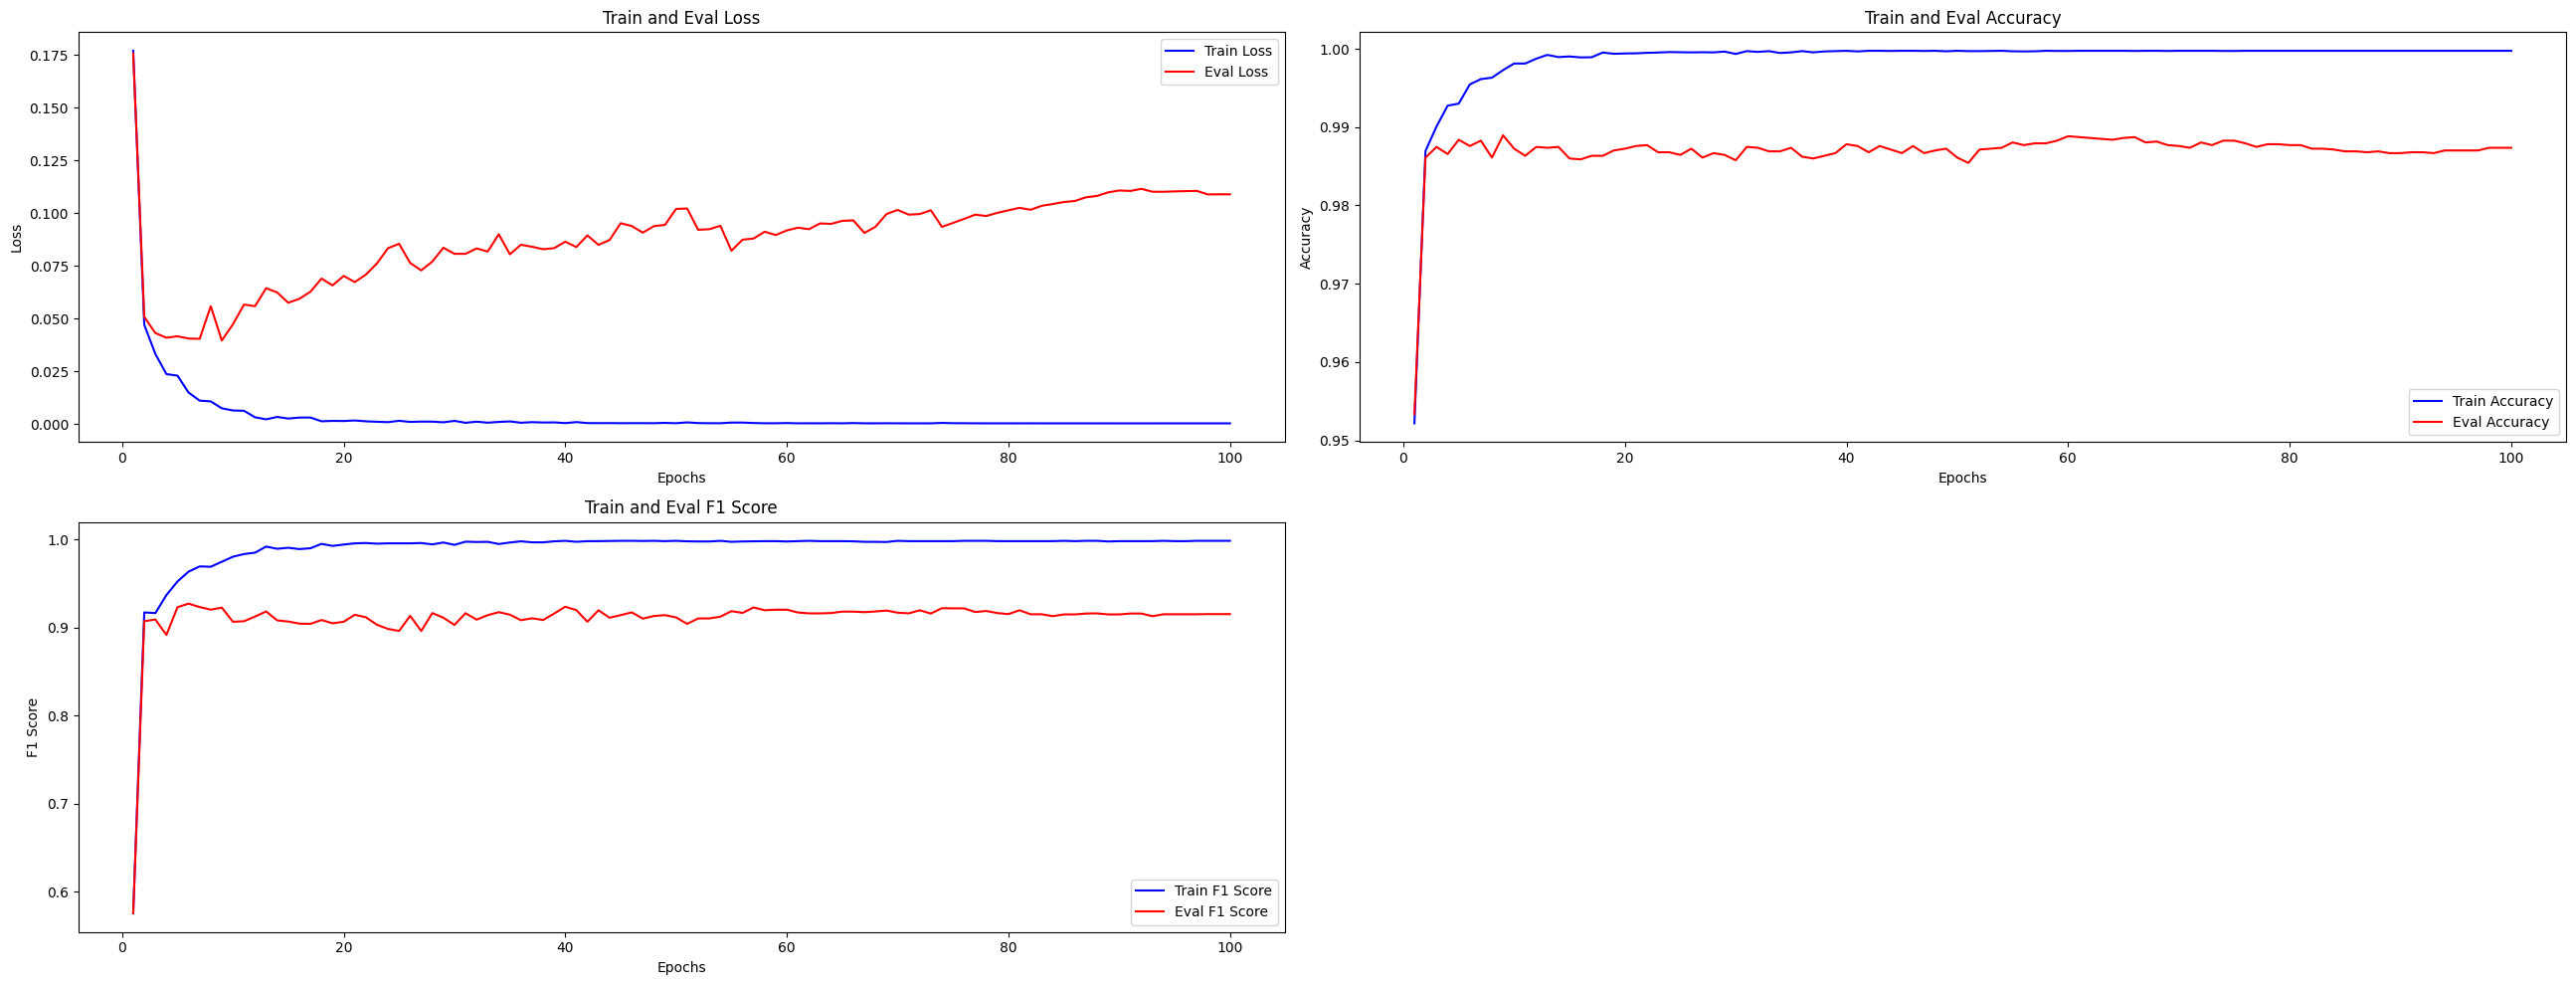

In [23]:
# plot train and eval loss accuracy and f1 score curves
fig, ax = plt.subplots(2, 2, figsize=(26, 10))

ax[0, 0].plot(train_logs['epoch'], train_logs['train_loss'], label='Train Loss', color='blue')
ax[0, 0].plot(eval_logs['epoch'], eval_logs['eval_loss'], label='Eval Loss', color='red')
ax[0, 0].set_title('Train and Eval Loss')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend()

ax[0, 1].plot(train_logs['epoch'], train_logs['train_accuracy_score'], label='Train Accuracy', color='blue')
ax[0, 1].plot(eval_logs['epoch'], eval_logs['eval_accuracy_score'], label='Eval Accuracy', color='red')
ax[0, 1].set_title('Train and Eval Accuracy')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('Accuracy')
ax[0, 1].legend()

ax[1, 0].plot(train_logs['epoch'], train_logs['train_f1'], label='Train F1 Score', color='blue')
ax[1, 0].plot(eval_logs['epoch'], eval_logs['eval_f1'], label='Eval F1 Score', color='red')
ax[1, 0].set_title('Train and Eval F1 Score')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('F1 Score')
ax[1, 0].legend()

fig.delaxes(ax[1, 1])
plt.tight_layout()
plt.show()

#### ***Model Inference***

In [47]:
sentence = "how can i get rid of aphids on my lettuce plants?"

# tokenize the sentence
inputs = tokenizer(sentence, return_tensors="pt")
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

print("Input IDs: ", input_ids.shape)
print("Attention Mask: ", attention_mask.shape)

Input IDs:  torch.Size([1, 18])
Attention Mask:  torch.Size([1, 18])


In [72]:
i = 0

input_ids = eval_dataset[i]['input_ids'].unsqueeze(0)
attention_mask = eval_dataset[i]['attention_mask'].unsqueeze(0)
labels = eval_dataset[i]['labels'].unsqueeze(0)

print("Input IDs: ", input_ids.shape)
print("Attention Mask: ", attention_mask.shape)

Input IDs:  torch.Size([1, 29])
Attention Mask:  torch.Size([1, 29])


In [73]:
# load distilbert model from saved checkpoint
model = DistilBertForTokenClassification.from_pretrained('./results_BIO/checkpoint-10500').to(device)

# get the model predictions
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

predictions = outputs.logits
predictions = predictions.detach().cpu().numpy()
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

# get the predicted tags
predicted_tags = [id2label[p] for p in predictions[0]]

# get the tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# print the tokens and their predicted tags
for token, tag, label in zip(tokens, predicted_tags, labels[0]):
    if token not in ['[CLS]', '[SEP]', '[PAD]']:
        print(f"{token} - {tag} - {id2label[label.item()]}")

the - O - O
strawberry - B-CROP - B-CROP
plants - O - O
in - O - O
my - O - O
farm - O - O
need - O - O
protection - O - O
from - O - O
birds - O - B-PEST
. - O - O
